# Model figures for all populations

## Import and define functions
[back to top](#Summarize-models)

In [1]:
import matplotlib as mpl
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style("white")
plt.style.use("huddlej")

In [3]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [4]:
colors = ['#d73027','#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4']

In [5]:
colors.reverse()

In [6]:
colors

['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#fc8d59', '#d73027']

In [7]:
ncols = 2
color_by_predictor = {
    'naive': '#000000',
    'offspring': '#000000',
    'normalized_fitness': '#000000',
    'fitness': '#000000',
    'ep': '#4575b4',
    'ep_wolf': '#4575b4',
    'ep_star': '#4575b4',
    'ep_x': '#4575b4',
    'rb': '#4575b4',
    'cTiter': '#91bfdb',
    'cTiter_x': '#91bfdb',
    'cTiterSub': '#91bfdb',
    'cTiterSub_star': '#91bfdb',
    'cTiterSub_x': '#91bfdb',
    'ne_star': '#999999',
    'dms_star': '#fee090',
    "dms_nonepitope": "#fee090",
    "dms_entropy": "#fee090",
    'unnormalized_lbi': '#fc8d59',
    'lbi': '#fc8d59',
    'delta_frequency': '#d73027'
}

name_by_predictor = {
    "naive": "naive",
    "offspring": "observed fitness",
    "normalized_fitness": "true fitness",
    "fitness": "estimated fitness",
    "ep": "epitope mutations",
    "ep_wolf": "Wolf epitope mutations",
    "ep_star": "epitope ancestor",
    "ep_x": "epitope cross-immunity",
    "rb": "Koel epitope mutations",
    "cTiter": "HI tree",
    "cTiter_x": "HI cross-immunity",
    "cTiterSub": "linear HI mut phenotypes",
    "cTiterSub_star": "ancestral HI mut phenotypes",
    "cTiterSub_x": "HI sub cross-immunity",
    "ne_star": "non-epitope mutations",
    "dms_star": "DMS mutational effects",
    "dms_nonepitope": "DMS non-epitope",
    "dms_entropy": "DMS entropy",
    "unnormalized_lbi": "unnormalized LBI",
    "lbi": "LBI",
    "delta_frequency": "delta frequency"
}

predictors_to_drop = [
    #"cTiter-ne_star",
    #"delta_frequency-ne_star",
    #"lbi-ep_x-ne_star"
]

In [8]:
def get_individual_predictors_for_data_frame(df):
    return [
        predictor
        for predictor in df["predictors"].unique()
        if "-" not in predictor and predictor != "naive"
    ]

def get_composite_predictors_for_data_frame(df):
    return [
        predictor
        for predictor in df["predictors"].unique()
        if "-" in predictor
    ]

In [9]:
def plot_accuracy_and_coefficients_for_build(errors_by_time_df, coefficients_by_time_df, predictors, rotation=30,
                                             years_fmt_string="%Y", date_fmt_string="%Y-%m-%d", height=12, width=12,
                                             text_vertical_padding=0.12, hspace=0.1, wspace=0.2, max_predictor_name_length=55,
                                             share_y=True, max_coefficient=None, max_normal_error=None, error_attribute="validation_error"):
    # Determine bounds for given data to set axes domains and ranges.
    min_normal_error = errors_by_time_df[error_attribute].min()
    std_normal_error = errors_by_time_df[error_attribute].std()
    min_normal_error -= 1.0 * std_normal_error
    
    if max_normal_error is None:
        max_normal_error = errors_by_time_df[error_attribute].max()
        max_normal_error += 2.0 * std_normal_error

    min_coefficient = coefficients_by_time_df["coefficient"].min()
    
    if max_coefficient is None:
        max_coefficient = coefficients_by_time_df["coefficient"].max() + 2

    min_date = errors_by_time_df["validation_timepoint"].min() - pd.DateOffset(months=6)
    max_date = errors_by_time_df["validation_timepoint"].max() + pd.DateOffset(months=6)
    
    nrows = len(predictors)
    
    fig, axes = plt.subplots(figsize=(width, height), facecolor='w')
    gs = gridspec.GridSpec(
        nrows=nrows,
        ncols=ncols,
        hspace=hspace,
        wspace=wspace
    )

    years = mdates.YearLocator(3)
    years_fmt = mdates.DateFormatter(years_fmt_string)
    months = mdates.MonthLocator()

    naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()
    naive_validation_error_df = naive_error_df[naive_error_df["error_type"] == "validation"].copy()
    naive_test_error_df = naive_error_df[naive_error_df["error_type"] == "test"].copy()
    
    # Get the start and end date for test data to enable visual delineation of these later data.
    test_start_date, test_end_date = naive_test_error_df["validation_timepoint"].aggregate(["min", "max"]).values

    for i, predictor in enumerate(predictors):
        error_df = errors_by_time_df[errors_by_time_df["predictors"] == predictor].copy()
        validation_error_df = error_df[error_df["error_type"] == "validation"].copy()
        test_error_df = error_df[error_df["error_type"] == "test"].copy()
        
        coefficient_df = coefficients_by_time_df[coefficients_by_time_df["predictors"] == predictor].copy()
        validation_coefficient_df = coefficient_df[coefficient_df["error_type"] == "validation"].copy()
        test_coefficient_df = coefficient_df[coefficient_df["error_type"] == "test"].copy()
        
        composite_predictors = predictor.split("-")
        composite_predictors_name = " + ".join([name_by_predictor[predictor_name] for predictor_name in composite_predictors])
        if len(composite_predictors_name) > max_predictor_name_length:
            predictor_name_spacing = "\n"
        else:
            predictor_name_spacing = " "

        distance_ax = plt.subplot(gs[i, 1])    
        distance_ax.set_xlabel("Date")
        distance_ax.set_ylabel("Distance\nto future")

        distance_ax.axhline(
            y=0.0,
            color="#cccccc"
        )

        # Plot validation data.
        distance_ax.plot(
            pd.to_datetime(naive_validation_error_df["validation_timepoint"]).astype(np.datetime64),
            naive_validation_error_df[error_attribute],
            "o-",
            color="#cccccc",
            zorder=-10,
            label="naive (train): %.2f +/- %.2f" % (naive_validation_error_df[error_attribute].mean(), naive_validation_error_df[error_attribute].std())
        )
        
        distance_ax.plot(
            pd.to_datetime(validation_error_df["validation_timepoint"]).astype(np.datetime64),
            validation_error_df[error_attribute],
            "o-",
            color="#000000",
            label="model (train): %.2f +/- %.2f" % (validation_error_df[error_attribute].mean(), validation_error_df[error_attribute].std())
        )
        
        validation_legend = distance_ax.legend(
            loc="upper left",
            frameon=False,
            fontsize=10
        )

        # Plot test data.
        naive_test_distance_handle_output = distance_ax.plot(
            pd.to_datetime(naive_test_error_df["validation_timepoint"]).astype(np.datetime64),
            naive_test_error_df[error_attribute],
            "o-",
            fillstyle="none",
            color="#cccccc",
            zorder=-10,
            label="naive (test): %.2f +/- %.2f" % (naive_test_error_df[error_attribute].mean(), naive_test_error_df[error_attribute].std())
        )
        
        model_test_distance_handle_output = distance_ax.plot(
            pd.to_datetime(test_error_df["validation_timepoint"]).astype(np.datetime64),
            test_error_df[error_attribute],
            "o-",
            fillstyle="none",
            color="#000000",
            label="model (test): %.2f +/- %.2f" % (test_error_df[error_attribute].mean(), test_error_df[error_attribute].std())
        )
        
        # Plot legend for test data.
        test_legend = distance_ax.legend(
            handles=[naive_test_distance_handle_output[0], model_test_distance_handle_output[0]],
            loc="upper right",
            frameon=False,
            fontsize=10
        )
        
        # Replot validation data legend, since it is replaced by the test data legend.
        distance_ax.add_artist(validation_legend)

        distance_ax.set_xlim(min_date, max_date)
        
        distance_ax.set_ylim(min_normal_error, max_normal_error)
        #distance_ax.set_ylim(0, max_normal_error + std_normal_error / 2)
        distance_ax.xaxis.set_major_locator(years)
        distance_ax.xaxis.set_major_formatter(years_fmt)
        distance_ax.xaxis.set_minor_locator(months)
        distance_ax.format_xdata = mdates.DateFormatter(date_fmt_string)

        coefficient_ax = plt.subplot(gs[i, 0])
        coefficient_ax.set_xlabel("Date")
        coefficient_ax.set_ylabel("Coefficient")
        
        if share_y:
            coefficient_ax.set_ylim(min_coefficient - 1, max_coefficient)

        coefficient_ax.axhline(
            y=0.0,
            color="#cccccc"
        )

        # Plot validation coefficients
        for predictor, predictor_coefficient_df in validation_coefficient_df.groupby("predictor"):
            coefficient_ax.plot(
                predictor_coefficient_df["validation_timepoint"],
                predictor_coefficient_df["coefficient"],
                "o-",
                color=color_by_predictor[predictor],
                label="%s: %.2f +/- %.2f" % (
                    name_by_predictor[predictor],
                    predictor_coefficient_df["coefficient"].mean(),
                    predictor_coefficient_df["coefficient"].std()
                )
            )
            
        coefficient_ax.legend(
            loc="upper left",
            frameon=False,
            fontsize=10
        )
        
        # Plot validation coefficients
        for predictor, predictor_coefficient_df in test_coefficient_df.groupby("predictor"):
            coefficient_ax.plot(
                predictor_coefficient_df["validation_timepoint"],
                predictor_coefficient_df["coefficient"],
                "o-",
                fillstyle="none",
                color=color_by_predictor[predictor],
                label="%s: %.2f +/- %.2f" % (
                    name_by_predictor[predictor],
                    predictor_coefficient_df["coefficient"].mean(),
                    predictor_coefficient_df["coefficient"].std()
                )
            )

        coefficient_ax.set_xlim(min_date, max_date)        
        coefficient_ax.xaxis.set_major_locator(years)
        coefficient_ax.xaxis.set_major_formatter(years_fmt)
        coefficient_ax.xaxis.set_minor_locator(months)
        coefficient_ax.format_xdata = mdates.DateFormatter(date_fmt_string)

    fig.autofmt_xdate(rotation=rotation, ha="center")
    gs.tight_layout(fig, h_pad=hspace)
    # show x-axis tick lines
    
    return (fig, axes, gs)

In [814]:
def plot_model_accuracy_and_coefficients_for_build(errors_by_time_df, coefficients_by_time_df, predictors, rotation=30,
                                             years_fmt_string="%Y", date_fmt_string="%Y-%m-%d", height=12, width=12,
                                             text_vertical_padding=0.12, hspace=0.1, wspace=0.2, max_predictor_name_length=55,
                                             share_y=True, max_coefficient=None, min_normal_error=None, max_normal_error=None,
                                             error_attribute="validation_error", distance_axis_label="Distance to\nfuture (AAs)"):
    # Determine bounds for given data to set axes domains and ranges.
    std_normal_error = errors_by_time_df[error_attribute].std()
    
    if max_normal_error is None:
        max_normal_error = errors_by_time_df[error_attribute].max()
        max_normal_error += 2.0 * std_normal_error

    if min_normal_error is None:
        #min_normal_error = errors_by_time_df[error_attribute].min()
        #min_normal_error -= 0.5 * std_normal_error
        min_normal_error = 0.0
        
    min_coefficient = coefficients_by_time_df["coefficient"].min()
    
    if max_coefficient is None:
        max_coefficient = coefficients_by_time_df["coefficient"].max() + 2

    min_date = errors_by_time_df["validation_timepoint"].min() - pd.DateOffset(months=6)
    max_date = errors_by_time_df["validation_timepoint"].max() + pd.DateOffset(months=6)
    
    nrows = len(predictors)
    
    naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()
    naive_validation_error_df = naive_error_df[naive_error_df["error_type"] == "validation"].copy()
    naive_test_error_df = naive_error_df[naive_error_df["error_type"] == "test"].copy()
    total_validation_timepoints = naive_validation_error_df.shape[0]
    total_timepoints = naive_error_df.shape[0]
    
    fig, axes = plt.subplots(figsize=(width, height), facecolor='w')
    gs = gridspec.GridSpec(
        nrows=nrows,
        ncols=ncols,
        hspace=hspace,
        wspace=wspace
        #width_ratios=[(total_validation_timepoints + 2) / float(total_timepoints), 1.0]
    )

    years = mdates.YearLocator(3)
    years_fmt = mdates.DateFormatter(years_fmt_string)
    months = mdates.MonthLocator()
    
    # Get the start and end date for test data to enable visual delineation of these later data.
    test_start_date, test_end_date = naive_test_error_df["validation_timepoint"].aggregate(["min", "max"]).values

    for i, predictor in enumerate(predictors):
        error_df = errors_by_time_df[errors_by_time_df["predictors"] == predictor].copy()
        validation_error_df = error_df[error_df["error_type"] == "validation"].copy()
        test_error_df = error_df[error_df["error_type"] == "test"].copy()
        
        coefficient_df = coefficients_by_time_df[coefficients_by_time_df["predictors"] == predictor].copy()
        validation_coefficient_df = coefficient_df[coefficient_df["error_type"] == "validation"].copy()
        test_coefficient_df = coefficient_df[coefficient_df["error_type"] == "test"].copy()
        
        composite_predictors = predictor.split("-")
        composite_predictors_name = " + ".join([name_by_predictor[predictor_name] for predictor_name in composite_predictors])
        if len(composite_predictors_name) > max_predictor_name_length:
            predictor_name_spacing = "\n"
        else:
            predictor_name_spacing = " "

        distance_ax = plt.subplot(gs[i, 1])    
        distance_ax.set_xlabel("Date")
        distance_ax.set_ylabel(distance_axis_label)

        distance_ax.axhline(
            y=0.0,
            color="#cccccc"
        )

        # Plot validation data.        
        distance_ax.plot(
            pd.to_datetime(validation_error_df["validation_timepoint"]).astype(np.datetime64),
            validation_error_df[error_attribute],
            "o-",
            color="#000000",
            label="validation: %.2f +/- %.2f" % (validation_error_df[error_attribute].mean(), validation_error_df[error_attribute].std())
        )
        
        # Plot distance from current timepoint to future.
        distance_ax.plot(
            pd.to_datetime(naive_validation_error_df["validation_timepoint"]).astype(np.datetime64),
            naive_validation_error_df[error_attribute],
            "o-",
            color="#cccccc",
            label="",
            zorder=-10
        )
        
        # Plot test data.
        if test_error_df.shape[0] > 0:
            model_test_distance_handle_output = distance_ax.plot(
                pd.to_datetime(test_error_df["validation_timepoint"]).astype(np.datetime64),
                test_error_df[error_attribute],
                "o-",
                fillstyle="none",
                color="#000000",
                label="test: %.2f +/- %.2f" % (test_error_df[error_attribute].mean(), test_error_df[error_attribute].std())
            )
            
            # Plot future distance to itself for this timepoint (the optimal).
            distance_ax.plot(
                pd.to_datetime(naive_test_error_df["validation_timepoint"]).astype(np.datetime64),
                naive_test_error_df[error_attribute],
                "o-",
                fillstyle="none",
                color="#cccccc",
                label="",
                zorder=-10
            )
        
        distance_ax.legend(
            loc="upper left",
            frameon=False,
            fontsize=12,
            ncol=2
        )
        
        """# Highlight validation window.
        rectangle = plt.Rectangle(
            (test_start_date, min_normal_error),
            test_end_date - test_start_date,
            max_normal_error - min_normal_error,
            fc='#cccccc',
            alpha=0.5,
            zorder=-10
        )
        distance_ax.add_patch(rectangle)"""

        distance_ax.set_xlim(min_date, max_date)
        
        distance_ax.set_ylim(min_normal_error, max_normal_error)
        #distance_ax.set_ylim(0, max_normal_error + std_normal_error / 2)
        distance_ax.xaxis.set_major_locator(years)
        distance_ax.xaxis.set_major_formatter(years_fmt)
        distance_ax.xaxis.set_minor_locator(months)
        distance_ax.format_xdata = mdates.DateFormatter(date_fmt_string)

        coefficient_ax = plt.subplot(gs[i, 0])
        coefficient_ax.set_xlabel("Date")
        coefficient_ax.set_ylabel("Coefficient")
        
        if share_y:
            coefficient_ax.set_ylim(min_coefficient - 1, max_coefficient)

        coefficient_ax.axhline(
            y=0.0,
            color="#cccccc"
        )

        # Plot validation coefficients
        for predictor, predictor_coefficient_df in validation_coefficient_df.groupby("predictor"):
            coefficient_ax.plot(
                predictor_coefficient_df["validation_timepoint"],
                predictor_coefficient_df["coefficient"],
                "o-",
                color=color_by_predictor[predictor],
                label="%s: %.2f +/- %.2f" % (
                    name_by_predictor[predictor],
                    predictor_coefficient_df["coefficient"].mean(),
                    predictor_coefficient_df["coefficient"].std()
                )
            )
            
        coefficient_ax.legend(
            loc="upper left",
            frameon=False,
            fontsize=12
        )

        # Plot fixed coefficients for testing
        for predictor, predictor_coefficient_df in test_coefficient_df.groupby("predictor"):
            coefficient_ax.plot(
                predictor_coefficient_df["validation_timepoint"],
                predictor_coefficient_df["coefficient"],
                "o-",
                fillstyle="none",
                color=color_by_predictor[predictor],
                label="%s: %.2f +/- %.2f" % (
                    name_by_predictor[predictor],
                    predictor_coefficient_df["coefficient"].mean(),
                    predictor_coefficient_df["coefficient"].std()
                )
            )

        coefficient_ax.set_xlim(min_date, max_date)
        coefficient_ax.xaxis.set_major_locator(years)
        coefficient_ax.xaxis.set_major_formatter(years_fmt)
        coefficient_ax.xaxis.set_minor_locator(months)
        coefficient_ax.format_xdata = mdates.DateFormatter(date_fmt_string)

    fig.autofmt_xdate(rotation=rotation, ha="center")
    gs.tight_layout(fig, h_pad=hspace)
    # show x-axis tick lines
    
    return (fig, axes, gs)

In [807]:
def prepare_table(errors_df, coefficients_df, text_width=0.9):
    error_metric = "validation_error"
    
    coefficient_columns = ["model", "predictor", "coefficient_mean", "coefficient_std"]
    model_selection_coefficients = coefficients_df.groupby(["model", "predictor"], sort=False).aggregate({
        "coefficient": ["mean", "std"]
    }).reset_index()
    model_selection_coefficients.columns = coefficient_columns
    
    model_selection_errors = errors_df.groupby("model").aggregate({
        error_metric: ["mean", "std"],
        "distance_from_future": ["mean", "std"],
        "model_better_than_naive": ["sum", "mean"]
    }).sort_values((error_metric, "mean"), ascending=False)
    # .query("model != 'naive'")
    
    model_selection_errors.loc[:, ("model_better_than_naive", "sum")] = model_selection_errors[("model_better_than_naive", "sum")].astype(int)
    
    columns = [
        "model",
        "%s_mean" % error_metric,
        "%s_std" % error_metric,
        "distance_from_future_mean",
        "distance_from_future_std",
        "model_better_count",
        "model_better_proportion"
    ]
    model_selection_errors = np.around(model_selection_errors, 2).reset_index()
    model_selection_errors.columns = columns
    model_selection_errors = model_selection_errors.sort_values("%s_mean" % error_metric, ascending=True)
    
    model_selection = model_selection_errors.merge(
        model_selection_coefficients,
        on=["model"]
    )
    
    model_selection["coefficients"] = model_selection.apply(
        lambda row: "%.2f +/- %.2f" % (row["coefficient_mean"], row["coefficient_std"]),
        axis=1
    )

    model_selection[error_metric] = model_selection.apply(
        lambda row: "%.2f +/- %.2f" % (row["%s_mean" % error_metric], row["%s_std" % error_metric]),
        axis=1
    )
    
    model_selection["distance_from_future"] = model_selection.apply(
        lambda row: "%.2f +/- %.2f" % (row["distance_from_future_mean"], row["distance_from_future_std"]),
        axis=1
    )

    model_selection["model_better"] = model_selection.apply(
        lambda row: "%i (%i\%%)" % (row["model_better_count"], int(row["model_better_proportion"] * 100)),
        axis=1
    )
    
    simple_model_selection_columns = ["model", "coefficients", error_metric, "distance_from_future", "model_better"]
    simple_model_selection = []

    for model, model_df in model_selection.loc[:, simple_model_selection_columns].groupby("model", sort=False):
        new_model_predictors = model.split(" + ")
        new_coefficients = model_df["coefficients"].values
        
        for i in range(len(new_model_predictors)):
            if i == 0:
                if len(new_model_predictors) > 1:
                    new_model_predictor = new_model_predictors[i] + " +"
                else:
                    new_model_predictor = new_model_predictors[i]
                    
                new_validation_error = model_df[error_metric].values[0]
                new_distance_from_future = model_df["distance_from_future"].values[0]
                new_model_better = model_df["model_better"].values[0]
            else:
                new_model_predictor = "\hspace{3mm}" + new_model_predictors[i]
                new_validation_error = ""
                new_distance_from_future = ""
                new_model_better = ""
                
            simple_model_selection.append({
                "model": new_model_predictor,
                "coefficients": new_coefficients[i],
                error_metric: new_validation_error,
                "distance_from_future": new_distance_from_future,
                "model_better": new_model_better
            })

    simple_model_selection = pd.DataFrame(simple_model_selection, columns=simple_model_selection_columns)
    simple_model_selection.columns = [
        "Model",
        "Coefficients",
        "\makecell{Distance to \\\\ future (AAs)}",
        "\makecell{Approx. of future \\\\ diversity (AAs)}",
        "\makecell[l]{Model $>$ naive \\\\ (N=%i)}" % errors_df["validation_timepoint"].unique().shape[0]
    ]
    
    # Update pandas options for maximum column width to display so longer cells do not get truncates in LaTeX.
    with pd.option_context("max_colwidth", 1000):
        simple_model_selection_table = simple_model_selection.to_latex(index=False, escape=False, column_format="lrrrl").replace(
            "tabular}",
            "tabular*}"
        ).replace(
            "{tabular*}{",
            "{tabular*}{%s\\textwidth}{" % text_width
        )
        
    return simple_model_selection_table

## Load data

In [748]:
simulated_sample = "simulated_sample_3"
natural_sample = "natural_sample_1_with_90_vpm_sliding"
luksza_sample = "luksza_lassig"

In [749]:
errors_file = "../results/distance_model_errors.tsv"
coefficients_file = "../results/distance_model_coefficients.tsv"

In [750]:
errors_by_time_df = pd.read_csv(errors_file, sep="\t", parse_dates=["validation_timepoint"])

In [751]:
errors_by_time_df["sample"].unique()

array(['simulated_sample_3', 'natural_sample_0_with_90_vpm_sliding',
       'natural_sample_1_with_90_vpm_sliding'], dtype=object)

In [752]:
errors_by_time_df = pd.read_csv(errors_file, sep="\t", parse_dates=["validation_timepoint"])
errors_by_time_df = errors_by_time_df[~errors_by_time_df["predictors"].isin(predictors_to_drop)].copy()
errors_by_time_df["model_improvement"] = errors_by_time_df["null_validation_error"] - errors_by_time_df["validation_error"]
errors_by_time_df["log2_model_improvement"] = np.log2(errors_by_time_df["null_validation_error"] / errors_by_time_df["validation_error"])
errors_by_time_df["relative_improvement"] = (
    errors_by_time_df["null_validation_error"] - errors_by_time_df["validation_error"]
) / errors_by_time_df["null_validation_error"]
errors_by_time_df["proportion_by_model"] = errors_by_time_df["validation_error"] / errors_by_time_df["null_validation_error"]
errors_by_time_df["proportion_explained"] = 1 - (errors_by_time_df["validation_error"] / errors_by_time_df["null_validation_error"])
errors_by_time_df["distance_from_future"] = errors_by_time_df["average_distance_to_future"] - errors_by_time_df["average_diversity_in_future"]

simulated_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == simulated_sample].copy()
natural_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == natural_sample].copy()
luksza_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == luksza_sample].copy()

In [753]:
simulated_errors_by_time_df.shape

(530, 18)

In [754]:
natural_errors_by_time_df.shape

(483, 18)

In [755]:
luksza_errors_by_time_df.shape

(0, 18)

In [756]:
coefficients_by_time_df = pd.read_csv(coefficients_file, sep="\t", parse_dates=["validation_timepoint"])
coefficients_by_time_df = coefficients_by_time_df[~coefficients_by_time_df["predictors"].isin(predictors_to_drop)].copy()

simulated_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == simulated_sample].copy()
natural_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == natural_sample].copy()
luksza_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == luksza_sample].copy()

In [757]:
simulated_coefficients_by_time_df.shape

(689, 7)

In [758]:
natural_coefficients_by_time_df.shape

(621, 7)

In [759]:
luksza_coefficients_by_time_df.shape

(0, 7)

In [760]:
get_individual_predictors_for_data_frame(simulated_errors_by_time_df)

['normalized_fitness', 'ep_star', 'ep_x', 'ne_star', 'lbi', 'delta_frequency']

In [761]:
get_composite_predictors_for_data_frame(simulated_errors_by_time_df)

['ep_star-ne_star', 'ep_x-ne_star', 'lbi-ne_star']

In [762]:
get_individual_predictors_for_data_frame(natural_errors_by_time_df)

['ep',
 'ep_wolf',
 'ep_star',
 'ep_x',
 'rb',
 'cTiter',
 'cTiter_x',
 'cTiterSub',
 'cTiterSub_x',
 'ne_star',
 'dms_star',
 'dms_nonepitope',
 'dms_entropy',
 'lbi',
 'delta_frequency']

In [763]:
get_composite_predictors_for_data_frame(natural_errors_by_time_df)

['ep_star-ne_star',
 'ep_x-ne_star',
 'ne_star-lbi',
 'cTiter_x-ne_star',
 'cTiter_x-ne_star-lbi']

In [764]:
simulated_errors_by_time_df.tail()

average_distance_to_future  average_diversity_in_future error_type  \
1141                    8.426235                     6.996952       test   
1142                    9.814498                     7.820351       test   
1143                    6.699094                     9.759254       test   
1144                    8.287754                    10.398832       test   
1145                    9.000471                    10.368544       test   

     future_timepoint  null_validation_error   predictors              sample  \
1141       2048-10-01              11.732285  lbi-ne_star  simulated_sample_3   
1142       2049-04-01              10.930322  lbi-ne_star  simulated_sample_3   
1143       2049-10-01               7.422700  lbi-ne_star  simulated_sample_3   
1144       2050-04-01               7.478334  lbi-ne_star  simulated_sample_3   
1145       2050-10-01               7.239005  lbi-ne_star  simulated_sample_3   

       timepoint       type  validation_error  validation_n  \
1141  2048-10-01  simulated          8.007600           630   
1142  2049-04-01  simulated          9.243744           630   
1143  2049-10-01  simulated          6.076969           630   
1144  2050-04-01  simulated          7.642506           630   
1145  2050-10-01  simulated          6.384298           630   

     validation_timepoint  model_improvement  log2_model_improvement  \
1141           2047-10-01           3.724686                0.551042   
1142           2048-04-01           1.686578                0.241787   
1143           2048-10-01           1.345731                0.288592   
1144           2049-04-01          -0.164172               -0.031329   
1145           2049-10-01           0.854707                0.181263   

      relative_improvement  proportion_by_model  proportion_explained  \
1141              0.317473             0.682527              0.317473   
1142              0.154303             0.845697              0.154303   
1143              0.181299             0.818701              0.181299   
1144             -0.021953             1.021953             -0.021953   
1145              0.118070             0.881930              0.118070   

      distance_from_future  
1141              1.429282  
1142              1.994147  
1143             -3.060160  
1144             -2.111078  
1145             -1.368072

## Distance to the future

### Simulated populations

In [ ]:
naive_simulated_validation_set = (
    (simulated_errors_by_time_df["predictors"] == "naive") & (simulated_errors_by_time_df["error_type"] == "validation")
)
naive_simulated_errors_by_time_df = simulated_errors_by_time_df[naive_simulated_validation_set]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(naive_simulated_errors_by_time_df, bins=10, label=None)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_simulated_errors_by_time_df.mean()
std_y = naive_simulated_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange",
    label="mean = %.2f +/- %.2f" % (mean_y, std_y)
)
ax.legend(
    frameon=False
)
ax.set_xlim(left=0)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-simulated-populations-between-timepoints.png")

### Natural populations

In [ ]:
naive_natural_validation_set = (
    (natural_errors_by_time_df["predictors"] == "naive") & (natural_errors_by_time_df["error_type"] == "validation")
)
naive_natural_errors_by_time_df = natural_errors_by_time_df[naive_natural_validation_set]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(naive_natural_errors_by_time_df, bins=10, label=None)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_natural_errors_by_time_df.mean()
std_y = naive_natural_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange",
    label="mean = %.2f +/- %.2f" % (mean_y, std_y)
)
ax.legend(
    frameon=False
)
ax.set_xlim(left=0)

plt.tight_layout()
#plt.savefig("../manuscript/figures/distance-of-natural-populations-between-timepoints.png")

### Luksza and Lassig populations

In [ ]:
naive_luksza_errors_by_time_df = luksza_errors_by_time_df[luksza_errors_by_time_df["predictors"] == "naive"]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(naive_luksza_errors_by_time_df, bins=10)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_luksza_errors_by_time_df.mean()
std_y = naive_luksza_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.5,
    0.8,
    "mean = %.2f +/- %.2f" % (mean_y, std_y),
    transform=ax.transAxes,
    fontsize=12,
    horizontalalignment="left"
)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-luksza-lassig-populations-between-timepoints.png")

## Figure 2: Summary of models for simulated populations

In [765]:
simulated_errors_by_time_df["model"] = simulated_errors_by_time_df["predictors"].apply(
    lambda predictor: " + ".join([name_by_predictor.get(predictor_name, predictor_name) for predictor_name in predictor.split("-")])
)
simulated_coefficients_by_time_df["model"] = simulated_coefficients_by_time_df["predictors"].apply(
    lambda predictor: " + ".join([name_by_predictor.get(predictor_name, predictor_name) for predictor_name in predictor.split("-")])
)

In [766]:
simulated_errors_by_time_df["model_better_than_naive"] = (simulated_errors_by_time_df["model_improvement"] > 0)
simulated_errors_by_time_df["relative_improvement"] = (
    simulated_errors_by_time_df["validation_error"] / simulated_errors_by_time_df["null_validation_error"]
) - 1.0

In [767]:
simulated_errors_by_time_df.head()

average_distance_to_future  average_diversity_in_future  error_type  \
0                   10.039711                     7.644399  validation   
1                    9.644649                     9.214787  validation   
2                   11.156790                     7.313337  validation   
3                   12.178027                     6.320209  validation   
4                   10.187963                     9.350948  validation   

  future_timepoint  null_validation_error predictors              sample  \
0       2024-10-01               8.870808      naive  simulated_sample_3   
1       2025-04-01               8.351673      naive  simulated_sample_3   
2       2025-10-01              10.027961      naive  simulated_sample_3   
3       2026-04-01              11.031343      naive  simulated_sample_3   
4       2026-10-01               8.814196      naive  simulated_sample_3   

    timepoint       type  validation_error  validation_n validation_timepoint  \
0  2024-10-01  simulated          8.870808           630           2023-10-01   
1  2025-04-01  simulated          8.351673           630           2024-04-01   
2  2025-10-01  simulated         10.027961           630           2024-10-01   
3  2026-04-01  simulated         11.031343           630           2025-04-01   
4  2026-10-01  simulated          8.814196           630           2025-10-01   

   model_improvement  log2_model_improvement  relative_improvement  \
0                0.0                     0.0                   0.0   
1                0.0                     0.0                   0.0   
2                0.0                     0.0                   0.0   
3                0.0                     0.0                   0.0   
4                0.0                     0.0                   0.0   

   proportion_by_model  proportion_explained  distance_from_future  model  \
0                  1.0                   0.0              2.395313  naive   
1                  1.0                   0.0              0.429862  naive   
2                  1.0                   0.0              3.843453  naive   
3                  1.0                   0.0              5.857817  naive   
4                  1.0                   0.0              0.837015  naive   

   model_better_than_naive  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False

In [768]:
simulated_validation_errors_by_time_df = simulated_errors_by_time_df.query("error_type == 'validation'").copy()
simulated_validation_coefficients_by_time_df = simulated_coefficients_by_time_df.query("error_type == 'validation'").copy()

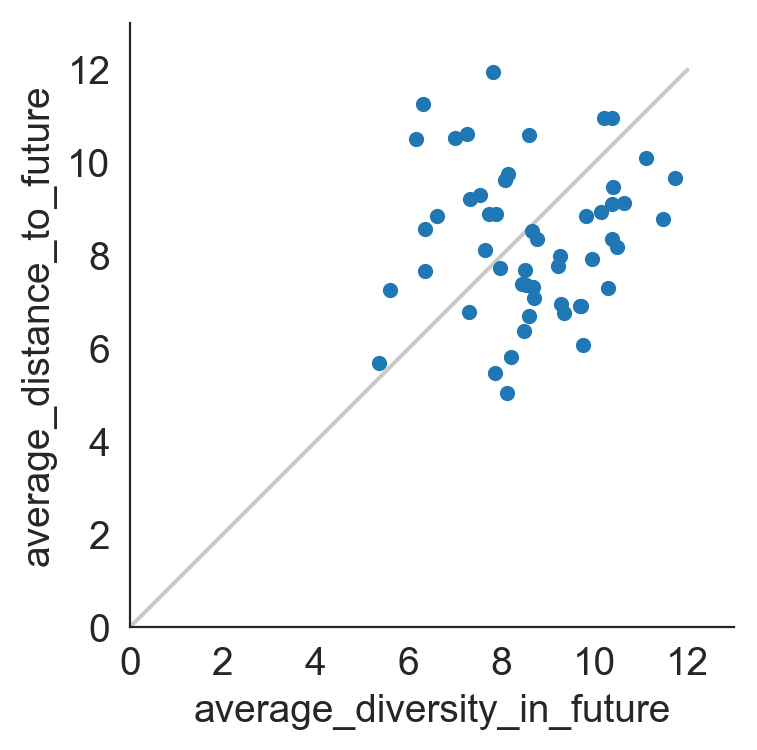

In [769]:
ax = simulated_errors_by_time_df.query("predictors == 'normalized_fitness'").plot(
    "average_diversity_in_future", "average_distance_to_future", kind="scatter"
)
ax.plot(np.arange(0, 13), np.arange(0, 13), zorder=-1, color="#999999", alpha=0.5)

ax.set_xticks(np.arange(0, 13, 2))
ax.set_yticks(np.arange(0, 13, 2))

ax.set_xlim(0, 13)
ax.set_ylim(0, 13)

ax.set_aspect("equal")

In [770]:
simple_simulated_model_selection_table = prepare_table(
    simulated_validation_errors_by_time_df,
    simulated_validation_coefficients_by_time_df,
    text_width=1.0
)

In [771]:
print(simple_simulated_model_selection_table)

\begin{tabular*}{1.0\textwidth}{lrrrl}
\toprule
                             Model &    Coefficients & \makecell{Distance to \\ future (AAs)} & \makecell{Approx. of future \\ diversity (AAs)} & \makecell[l]{Model $>$ naive \\ (N=33)} \\
\midrule
                      true fitness &   9.37 +/- 0.92 &                          6.82 +/- 1.52 &                                  -0.29 +/- 2.01 &                               32 (97\%) \\
                             LBI + &   1.31 +/- 0.33 &                          7.24 +/- 1.66 &                                  -0.33 +/- 2.00 &                               32 (97\%) \\
 \hspace{3mm}non-epitope mutations &  -1.77 +/- 0.49 &                                        &                                                 &                                         \\
                               LBI &   2.26 +/- 1.06 &                          7.57 +/- 1.85 &                                  -0.24 +/- 2.22 &                               29 (88\%) \

In [772]:
with open("../manuscript/tables/simulated_model_selection.tex", "w") as oh:
    oh.write(simple_simulated_model_selection_table)

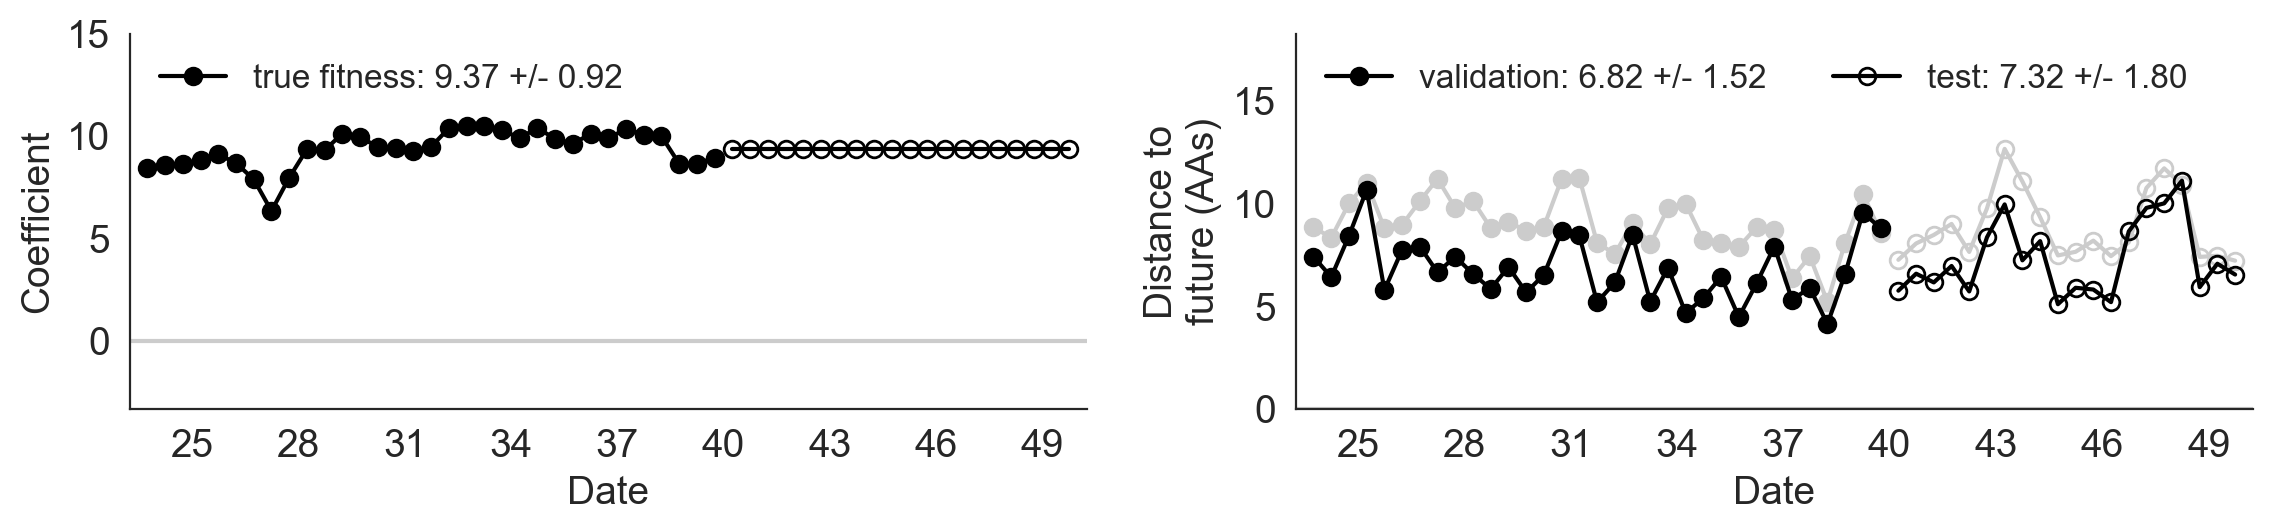

In [742]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    simulated_errors_by_time_df,
    simulated_coefficients_by_time_df,
    ["normalized_fitness"],
    rotation=0,
    years_fmt_string="%y",
    date_fmt_string="%y-%m",
    height=3,
    hspace=0.1,
    share_y=True,
    max_coefficient=15,
    min_normal_error=0.0
)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-simulated-populations-controls.png")

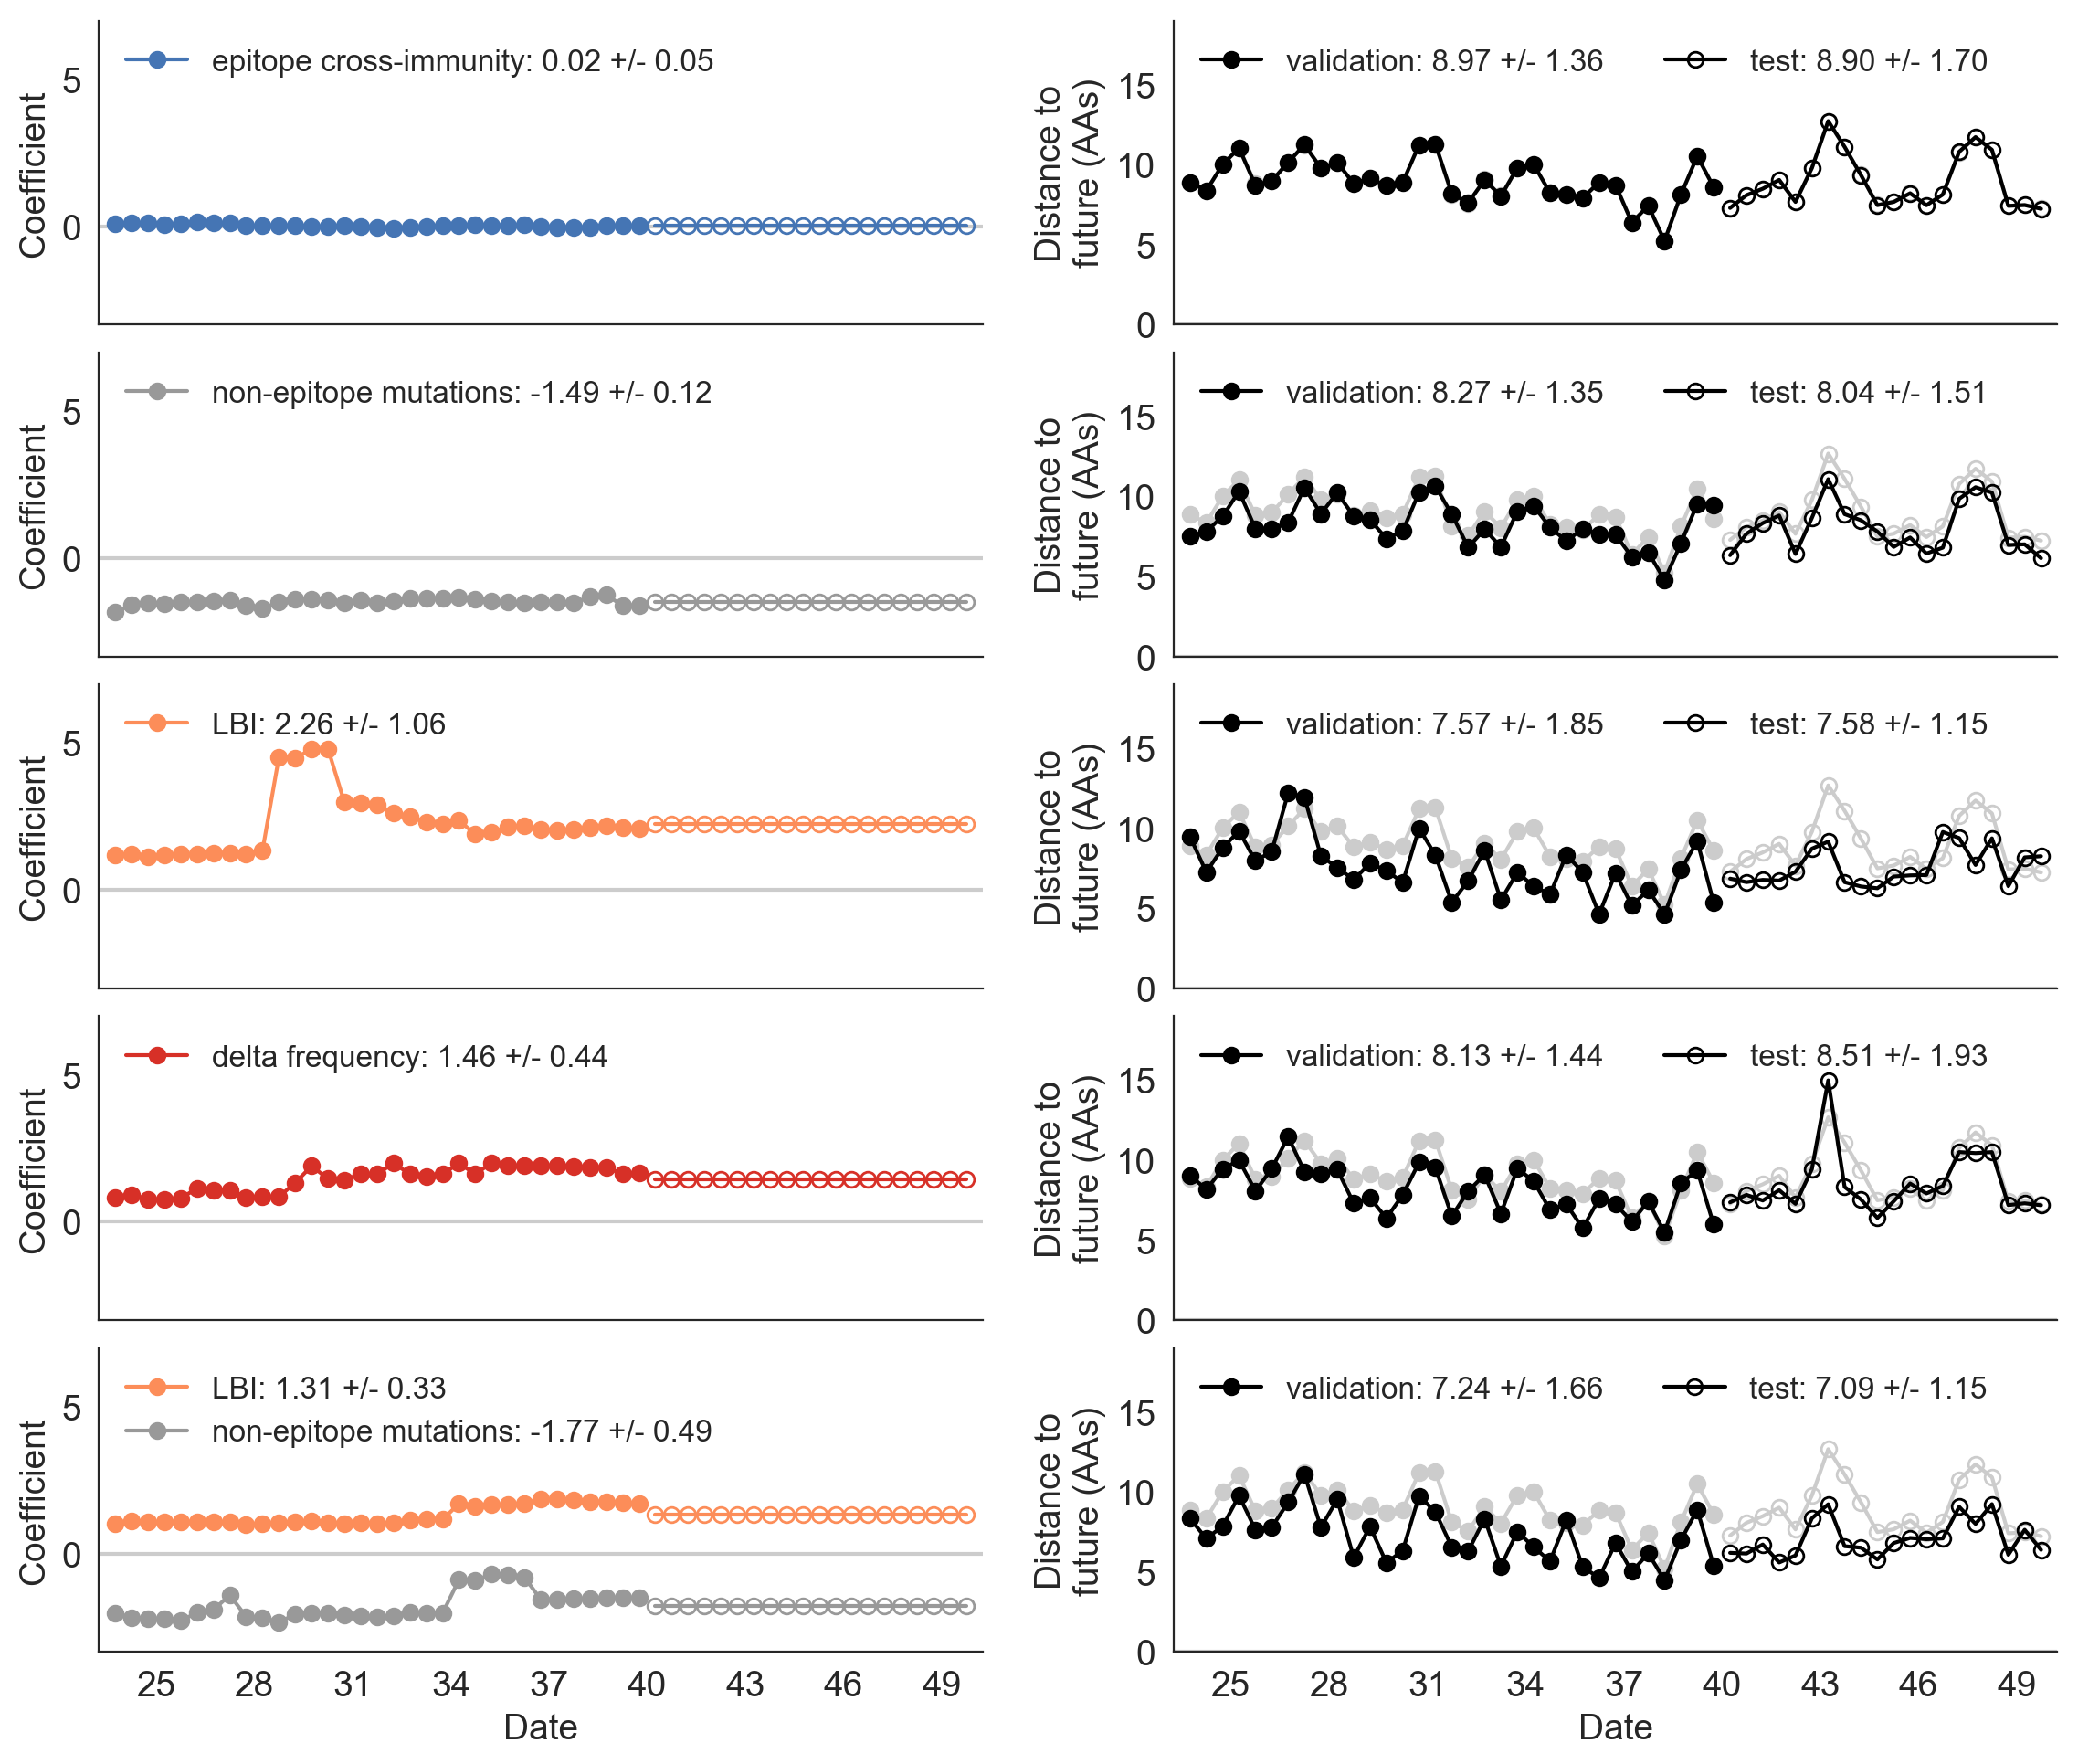

In [834]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    simulated_errors_by_time_df,
    simulated_coefficients_by_time_df,
    ["ep_x", "ne_star", "lbi", "delta_frequency", "lbi-ne_star"],
    rotation=0,
    years_fmt_string="%y",
    date_fmt_string="%y-%m",
    height=10,
    hspace=0.1,
    share_y=True,
    max_coefficient=7,
    min_normal_error=0.0,
    max_normal_error=19
)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-simulated-populations.png")

$$
D(u, u) = \sum_{i}x_{i}(u) \sum_{j}x_{j}(u)d(s_{i}, s_{j})
$$

$$
D(\hat{u}, u) = \sum_{i}x_{i}(\hat{u}) \sum_{j}x_{j}(u)d(s_{i}, s_{j})
$$

Text(0.5,1,'True fitness')

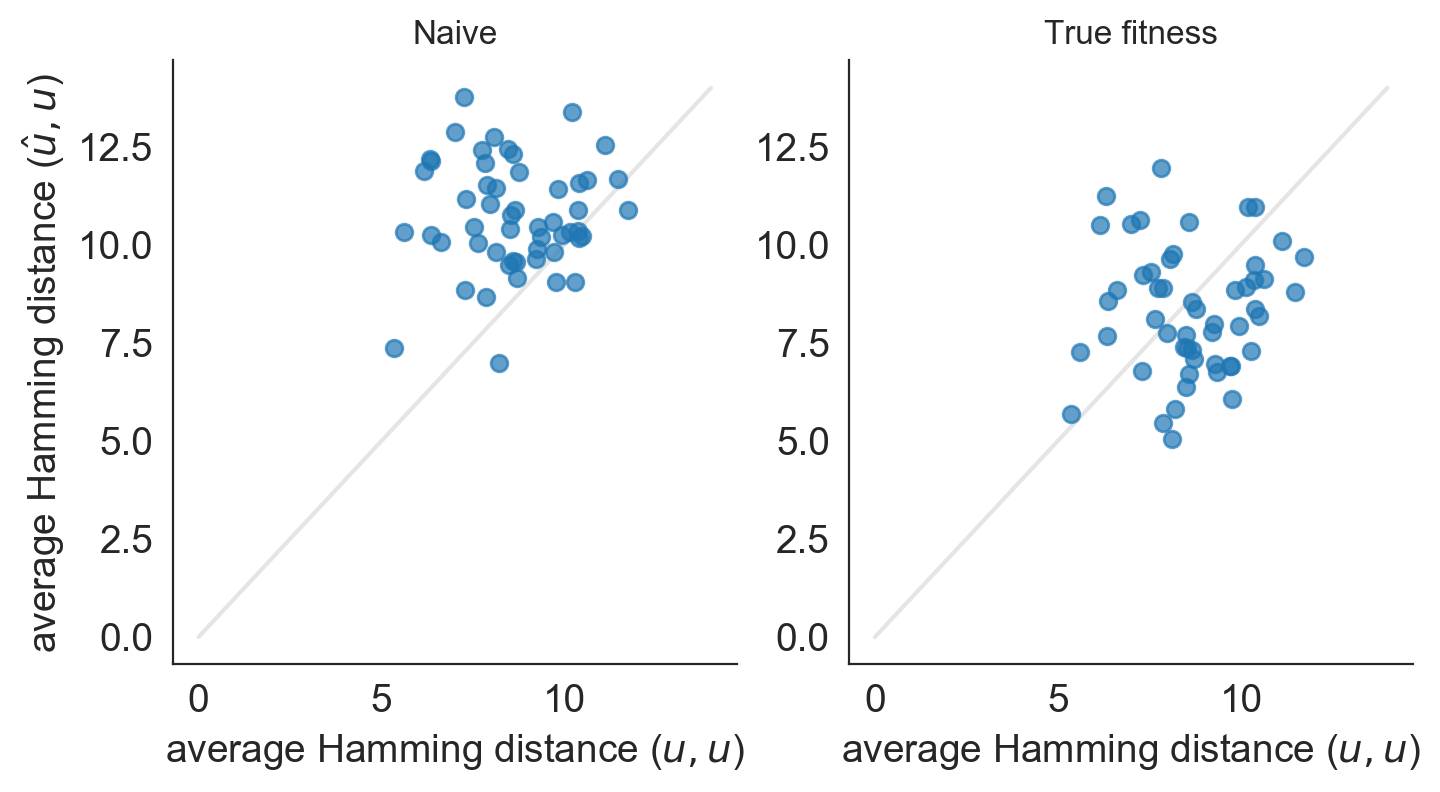

In [775]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].plot(
    simulated_errors_by_time_df.query("predictors == 'naive'")["average_diversity_in_future"],
    simulated_errors_by_time_df.query("predictors == 'naive'")["average_distance_to_future"],
    "o",
    alpha=0.7
)

max_value = 15
line = np.arange(max_value)
axes[0].plot(line, line, color="#cccccc", zorder=-1, alpha=0.5)
axes[0].set_xlabel("average Hamming distance ($u, u$)")
axes[0].set_ylabel("average Hamming distance ($\hat{u}, u$)")
axes[0].set_title("Naive", fontsize=12)

axes[1].plot(
    simulated_errors_by_time_df.query("predictors == 'normalized_fitness'")["average_diversity_in_future"],
    simulated_errors_by_time_df.query("predictors == 'normalized_fitness'")["average_distance_to_future"],
    "o",
    alpha=0.7
)

max_value = 15
line = np.arange(max_value)
axes[1].plot(line, line, color="#cccccc", zorder=-1, alpha=0.5)
axes[1].set_xlabel("average Hamming distance ($u, u$)")
#axes[1].set_ylabel("average Hamming distance ($\hat{u}, u$)")
axes[1].set_title("True fitness", fontsize=12)

Text(0,0.5,'average Hamming distance ($\\hat{u}, u$)')

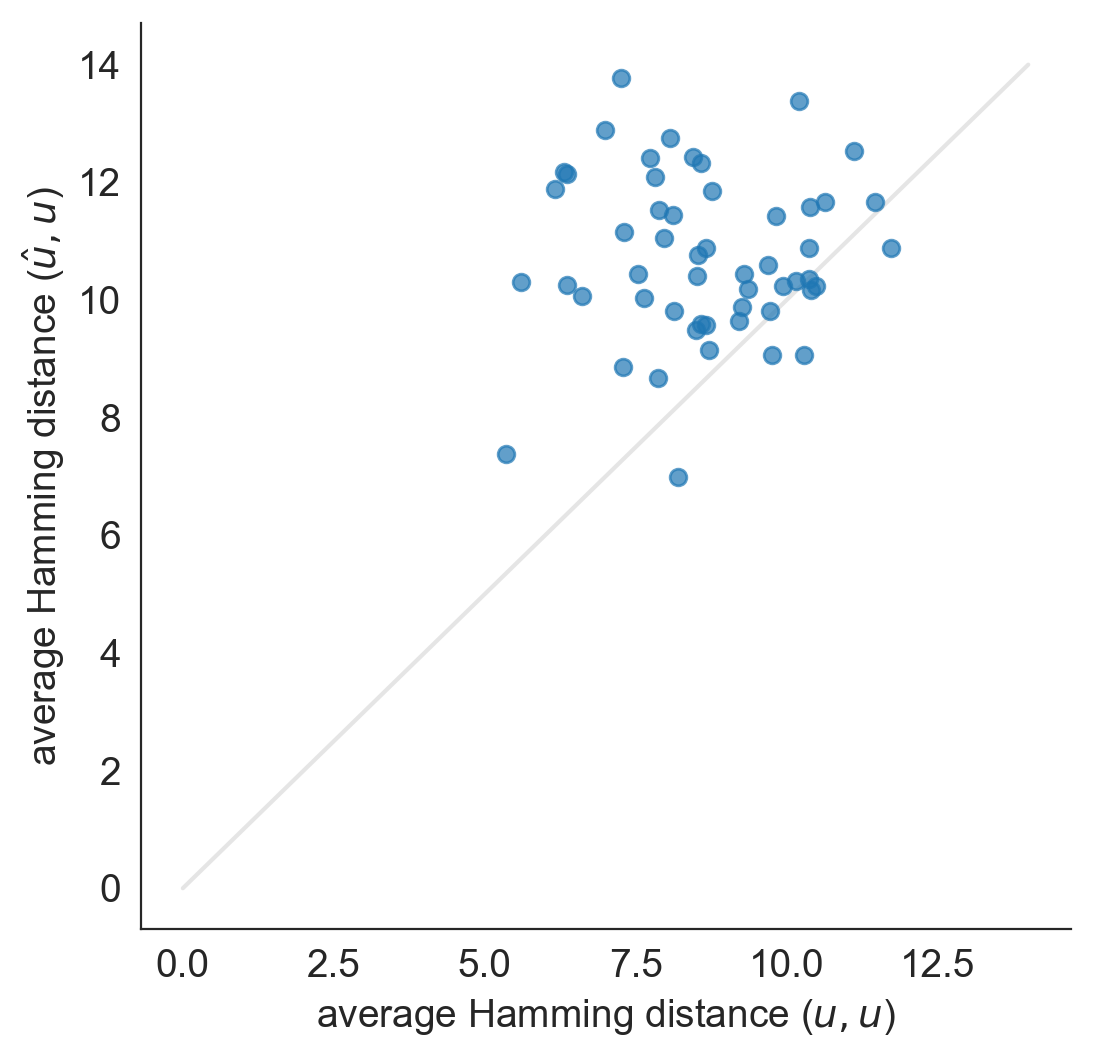

In [776]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(
    simulated_errors_by_time_df.query("predictors == 'naive'")["average_diversity_in_future"],
    simulated_errors_by_time_df.query("predictors == 'naive'")["average_distance_to_future"],
    "o",
    alpha=0.7
)

max_value = 15
line = np.arange(max_value)
ax.plot(line, line, color="#cccccc", zorder=-1, alpha=0.5)
ax.set_xlabel("average Hamming distance ($u, u$)")
ax.set_ylabel("average Hamming distance ($\hat{u}, u$)")

Text(0,0.5,'average Hamming distance ($\\hat{u}, u$)')

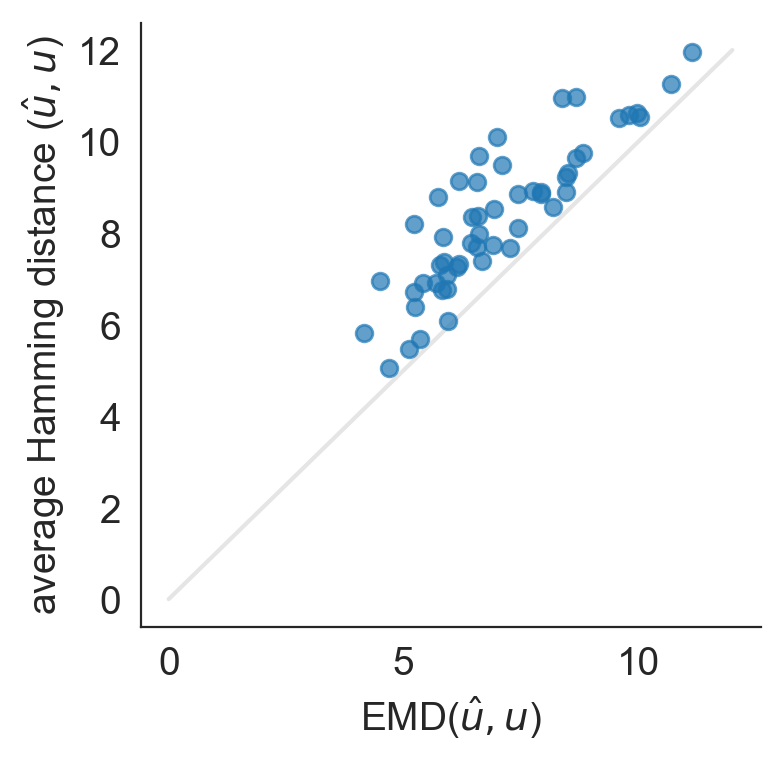

In [777]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(
    simulated_errors_by_time_df.query("predictors == 'normalized_fitness'")["validation_error"],
    simulated_errors_by_time_df.query("predictors == 'normalized_fitness'")["average_distance_to_future"],
    "o",
    alpha=0.7
)

max_value = 13
line = np.arange(max_value)
ax.plot(line, line, color="#cccccc", zorder=-1, alpha=0.5)
ax.set_xlabel("EMD($\hat{u}, u$)")
ax.set_ylabel("average Hamming distance ($\hat{u}, u$)")

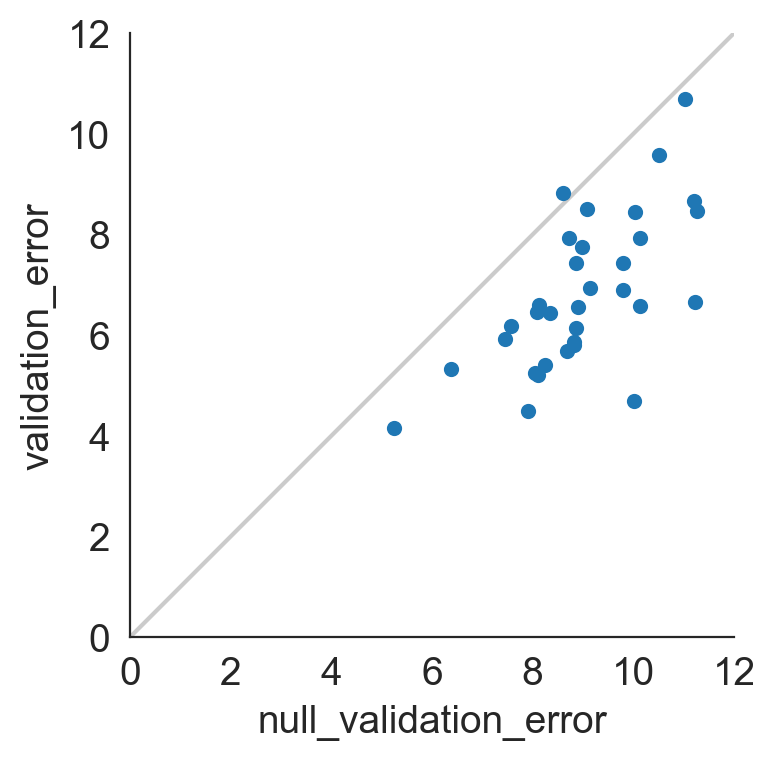

In [778]:
ax = simulated_validation_errors_by_time_df.query("predictors == 'normalized_fitness'").plot(
    "null_validation_error", "validation_error", kind="scatter"
)
ax.plot(np.arange(0, 13), np.arange(0, 13), zorder=-1, color="#999999", alpha=0.5)

ax.set_xticks(np.arange(0, 13, 2))
ax.set_yticks(np.arange(0, 13, 2))

ax.set_xlim(0, 12)
ax.set_ylim(0, 12)

ax.set_aspect("equal")

In [799]:
simulated_errors_by_time_df.loc[:, ["model", "predictors"]].drop_duplicates()

model          predictors
0                                             naive               naive
33                                     true fitness  normalized_fitness
66                                 epitope ancestor             ep_star
99                           epitope cross-immunity                ep_x
132                           non-epitope mutations             ne_star
165                                             LBI                 lbi
198                                 delta frequency     delta_frequency
231        epitope ancestor + non-epitope mutations     ep_star-ne_star
264  epitope cross-immunity + non-epitope mutations        ep_x-ne_star
297                     LBI + non-epitope mutations         lbi-ne_star

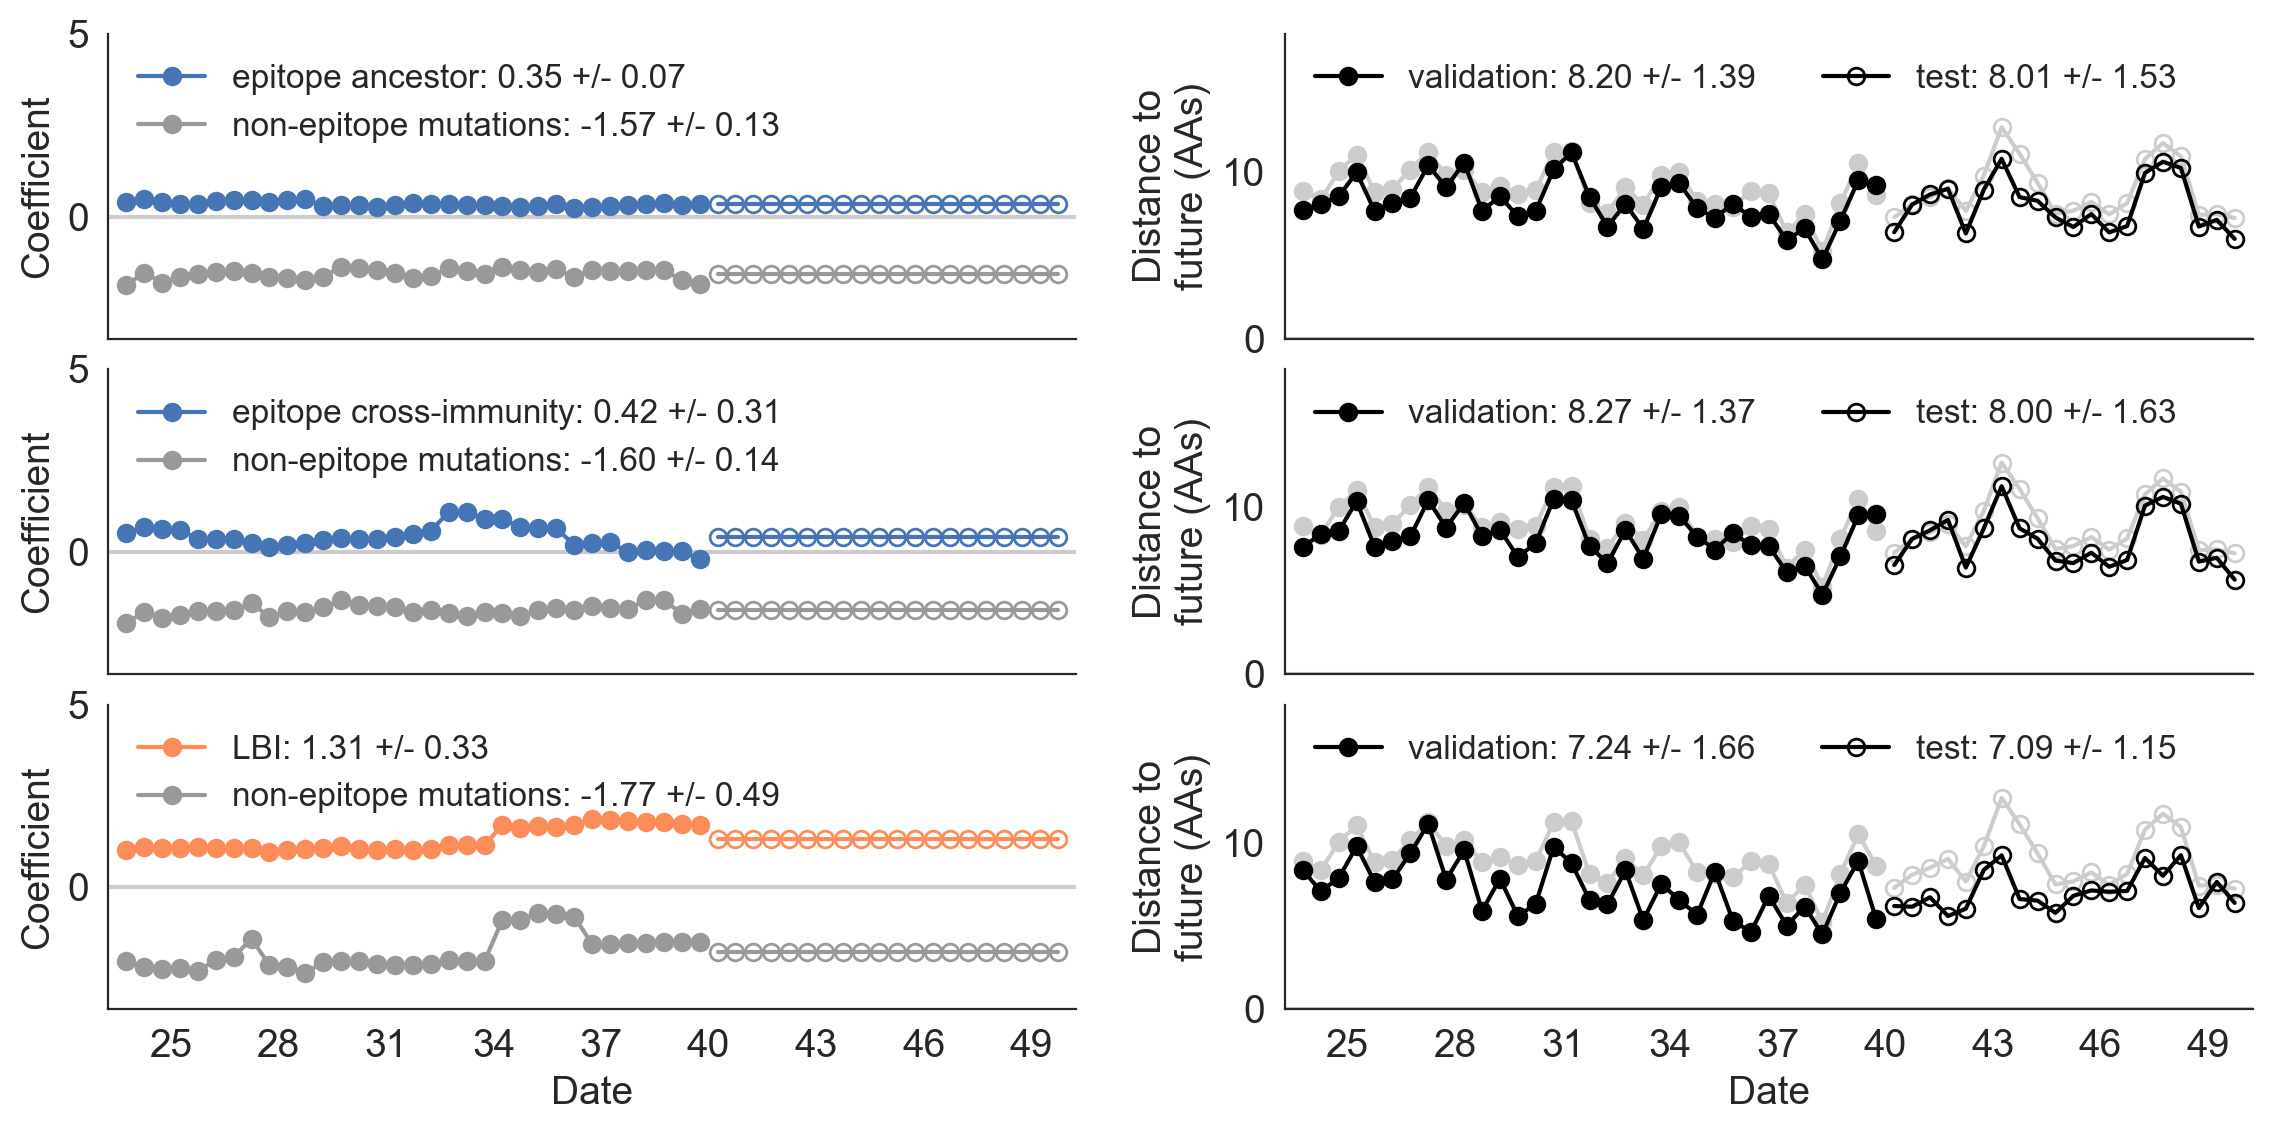

In [779]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    simulated_errors_by_time_df,
    simulated_coefficients_by_time_df,
    get_composite_predictors_for_data_frame(simulated_errors_by_time_df),
    rotation=0,
    years_fmt_string="%y",
    date_fmt_string="%y-%m",
    height=6,
    max_coefficient=5.0,
    min_normal_error=0.0
)
plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-simulated-populations.png")

## Figure 3: Summary of models for natural populations

In [817]:
subset_of_individual_predictors = [
    "ep_x",
    "cTiter_x",
    "ne_star",
    "dms_star",
    "lbi",
    "delta_frequency"
]

In [818]:
composite_models = [
    "cTiter_x-ne_star",
    "ne_star-lbi",
    "cTiter_x-ne_star-lbi"
]

In [782]:
natural_errors_by_time_df["validation_timepoint"].unique().shape

(23,)

In [783]:
natural_errors_by_time_df["model"] = natural_errors_by_time_df["predictors"].apply(
    lambda predictor: " + ".join([name_by_predictor.get(predictor_name, predictor_name) for predictor_name in predictor.split("-")])
)
natural_coefficients_by_time_df["model"] = natural_coefficients_by_time_df["predictors"].apply(
    lambda predictor: " + ".join([name_by_predictor.get(predictor_name, predictor_name) for predictor_name in predictor.split("-")])
)

In [784]:
natural_errors_by_time_df["model_better_than_naive"] = (natural_errors_by_time_df["model_improvement"] > 0)
natural_errors_by_time_df["relative_improvement"] = (
    natural_errors_by_time_df["validation_error"] / natural_errors_by_time_df["null_validation_error"]
) - 1.0

In [785]:
natural_validation_errors_by_time_df = natural_errors_by_time_df.query("error_type == 'validation'").copy()
natural_validation_coefficients_by_time_df = natural_coefficients_by_time_df.query("error_type == 'validation'").copy()

In [819]:
subset_of_natural_validation_errors_by_time_df = natural_validation_errors_by_time_df[
    natural_validation_errors_by_time_df["predictors"].isin(["naive"] + subset_of_individual_predictors + composite_models)
].copy()

subset_of_natural_validation_coefficients_by_time_df = natural_validation_coefficients_by_time_df[
    natural_validation_coefficients_by_time_df["predictors"].isin(["naive"] + subset_of_individual_predictors + composite_models)
].copy()

In [820]:
subset_of_natural_validation_errors_by_time_df.loc[:, ["model", "predictors"]].drop_duplicates()

model            predictors
463                                            naive                 naive
555                           epitope cross-immunity                  ep_x
624                                HI cross-immunity              cTiter_x
693                            non-epitope mutations               ne_star
716                           DMS mutational effects              dms_star
785                                              LBI                   lbi
808                                  delta frequency       delta_frequency
877                      non-epitope mutations + LBI           ne_star-lbi
900        HI cross-immunity + non-epitope mutations      cTiter_x-ne_star
923  HI cross-immunity + non-epitope mutations + LBI  cTiter_x-ne_star-lbi

In [821]:
subset_of_natural_validation_coefficients_by_time_df.loc[:, ["model", "predictors"]].drop_duplicates()

model            predictors
562                                             naive                 naive
654                            epitope cross-immunity                  ep_x
723                                 HI cross-immunity              cTiter_x
792                             non-epitope mutations               ne_star
815                            DMS mutational effects              dms_star
884                                               LBI                   lbi
907                                   delta frequency       delta_frequency
1022                      non-epitope mutations + LBI           ne_star-lbi
1068        HI cross-immunity + non-epitope mutations      cTiter_x-ne_star
1114  HI cross-immunity + non-epitope mutations + LBI  cTiter_x-ne_star-lbi

In [822]:
subset_of_natural_validation_coefficients_by_time_df.query("model == 'non-epitope mutations + LBI'").groupby(
    ["model", "predictor"],
    sort=False
).aggregate({
        "coefficient": ["mean", "std"]
    }).reset_index()

model predictor coefficient          
                                                mean       std
0  non-epitope mutations + LBI   ne_star   -0.675647  0.341181
1  non-epitope mutations + LBI       lbi    1.033714  0.402463

In [823]:
subset_natural_model_selection_table = prepare_table(
    subset_of_natural_validation_errors_by_time_df,
    subset_of_natural_validation_coefficients_by_time_df,
    text_width=1.0
)

In [824]:
print(subset_natural_model_selection_table)

\begin{tabular*}{1.0\textwidth}{lrrrl}
\toprule
                             Model &    Coefficients & \makecell{Distance to \\ future (AAs)} & \makecell{Approx. of future \\ diversity (AAs)} & \makecell[l]{Model $>$ naive \\ (N=23)} \\
\midrule
           non-epitope mutations + &  -0.68 +/- 0.34 &                          5.44 +/- 1.80 &                                  -0.02 +/- 1.50 &                               18 (78\%) \\
                   \hspace{3mm}LBI &   1.03 +/- 0.40 &                                        &                                                 &                                         \\
                               LBI &   1.12 +/- 0.51 &                          5.68 +/- 1.91 &                                   0.17 +/- 1.68 &                               17 (74\%) \\
               HI cross-immunity + &   1.39 +/- 0.19 &                          5.77 +/- 1.53 &                                   0.82 +/- 1.55 &                               18 (78\%) \

In [825]:
with open("../manuscript/tables/natural_model_selection.tex", "w") as oh:
    oh.write(subset_natural_model_selection_table)

Make a separate table with all models including those we do not discuss in the manuscript.

In [826]:
complete_natural_model_selection_table = prepare_table(
    natural_validation_errors_by_time_df,
    natural_validation_coefficients_by_time_df,
    text_width=1.0
)

with open("../manuscript/tables/complete_natural_model_selection.tex", "w") as oh:
    oh.write(complete_natural_model_selection_table)

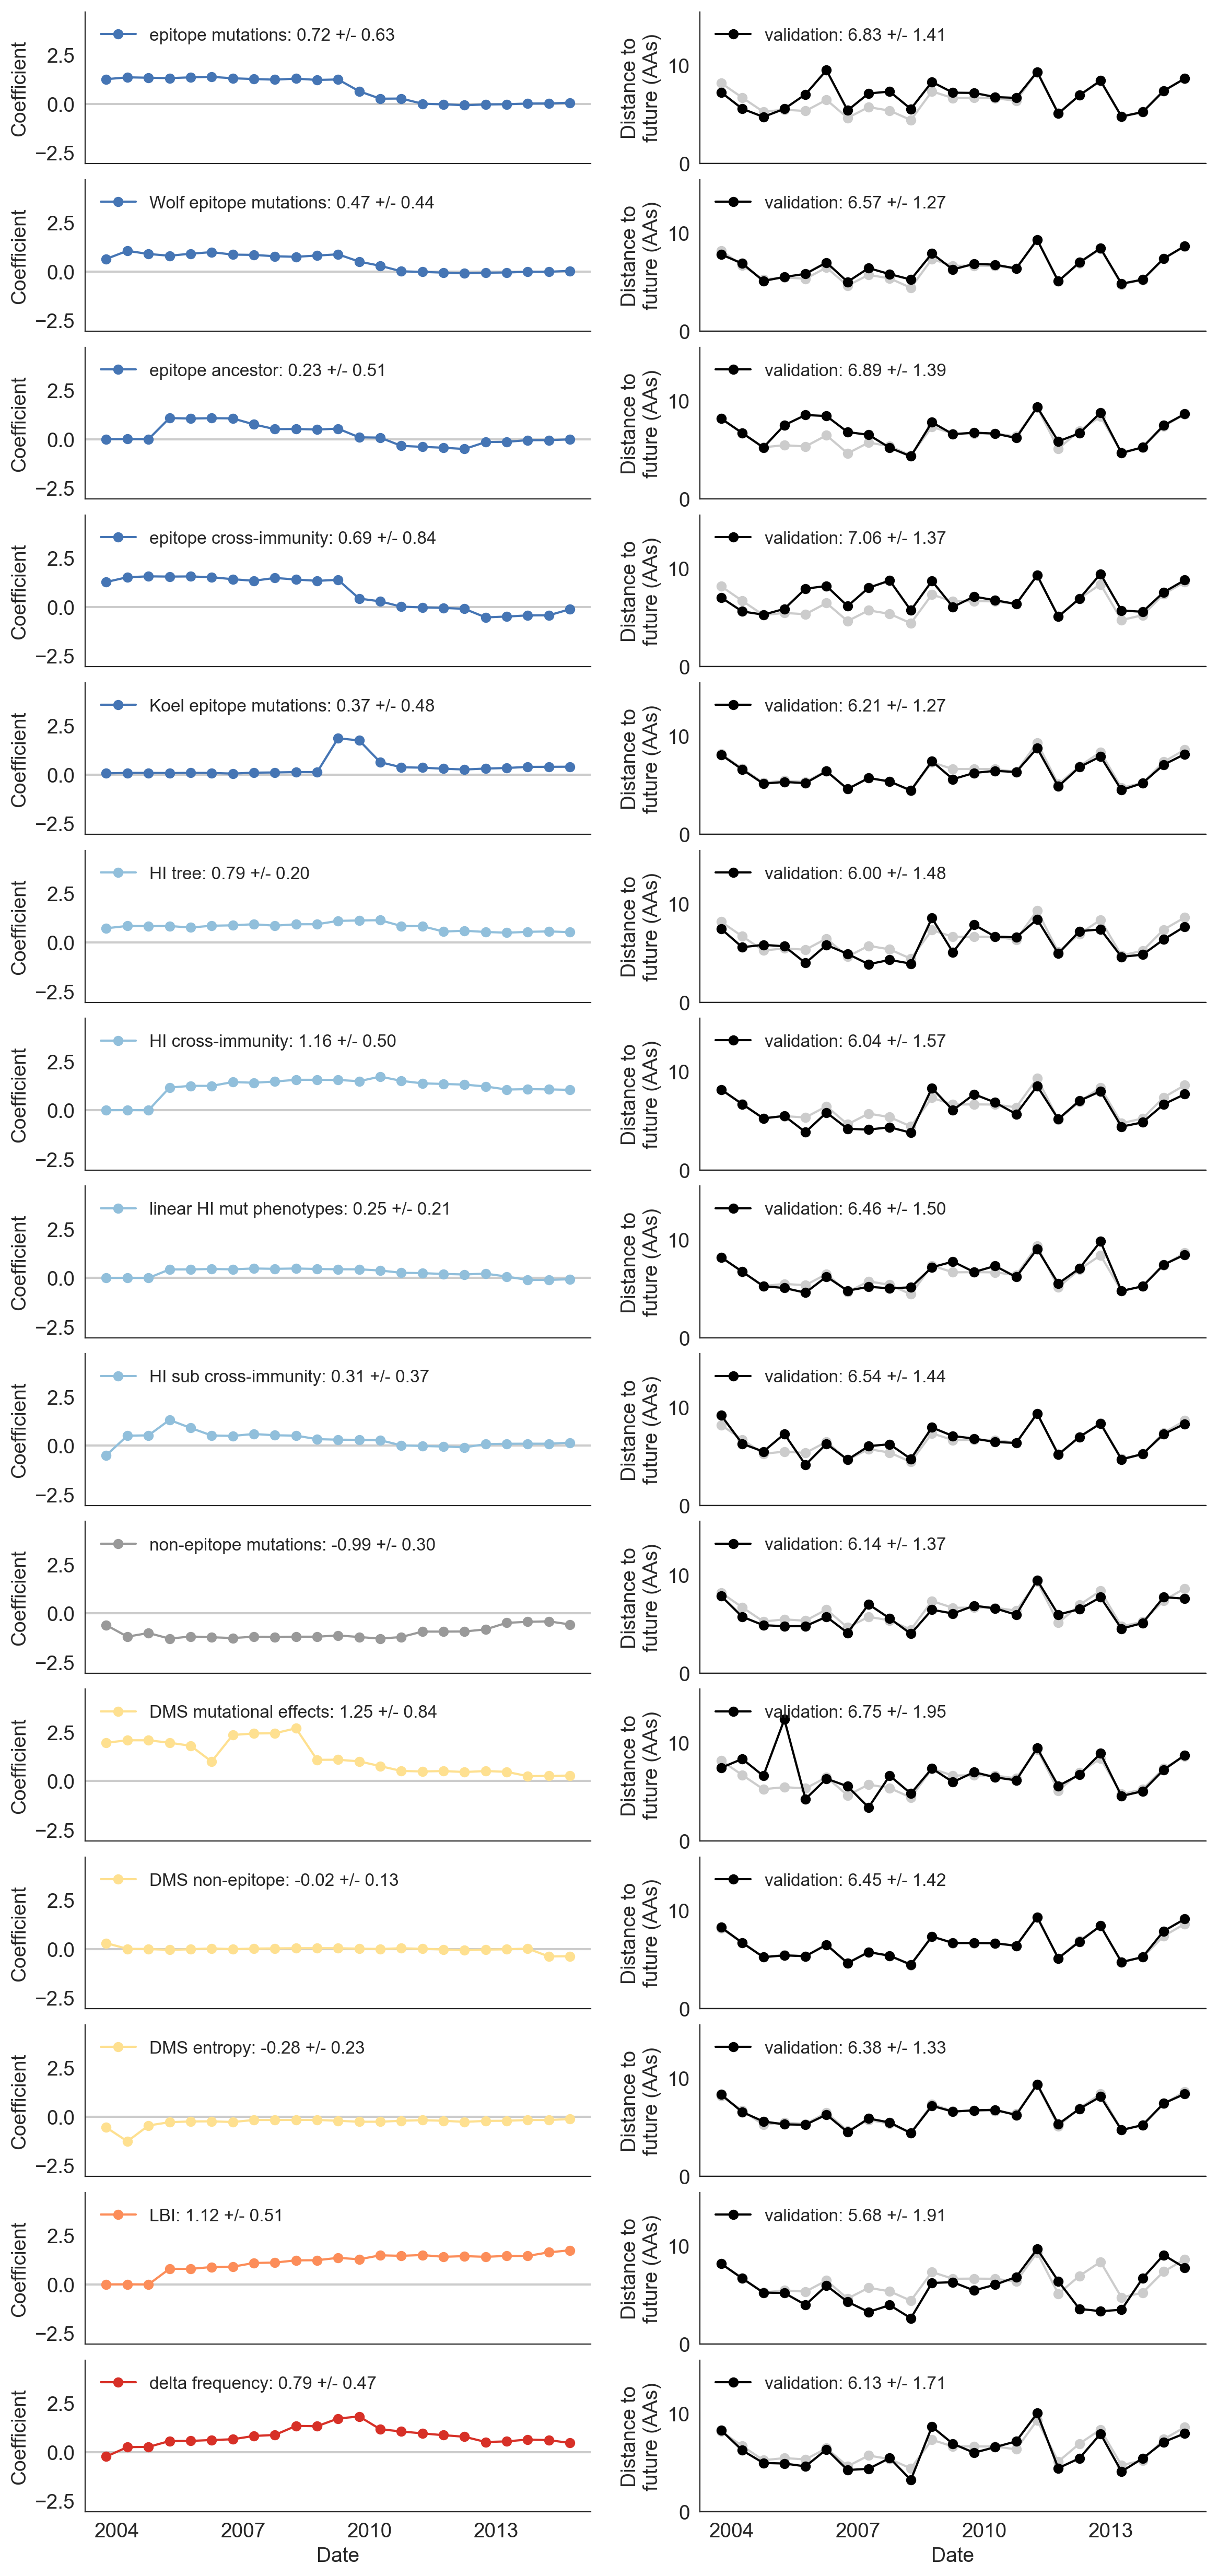

In [827]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(natural_errors_by_time_df),
    height=25,
    rotation=0
)
#plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-natural-populations-all-individual-predictors.png")

In [813]:
natural_errors_by_time_df.query("predictors == 'dms_star' & model_improvement > 1")

average_distance_to_future  average_diversity_in_future  error_type  \
720                    5.222529                     5.172072  validation   
723                    4.143921                     4.834295  validation   

    future_timepoint  null_validation_error predictors  \
720       2006-10-01               5.347614   dms_star   
723       2008-04-01               5.740692   dms_star   

                                   sample   timepoint     type  \
720  natural_sample_1_with_90_vpm_sliding  2006-10-01  natural   
723  natural_sample_1_with_90_vpm_sliding  2008-04-01  natural   

     validation_error  validation_n validation_timepoint  model_improvement  \
720          4.274793           469           2005-10-01           1.072821   
723          3.419894           431           2007-04-01           2.320798   

     log2_model_improvement  relative_improvement  proportion_by_model  \
720                0.323041             -0.200617             0.799383   
723                0.747273             -0.404271             0.595729   

     proportion_explained  distance_from_future                   model  \
720              0.200617              0.050457  DMS mutational effects   
723              0.404271             -0.690374  DMS mutational effects   

     model_better_than_naive  
720                     True  
723                     True

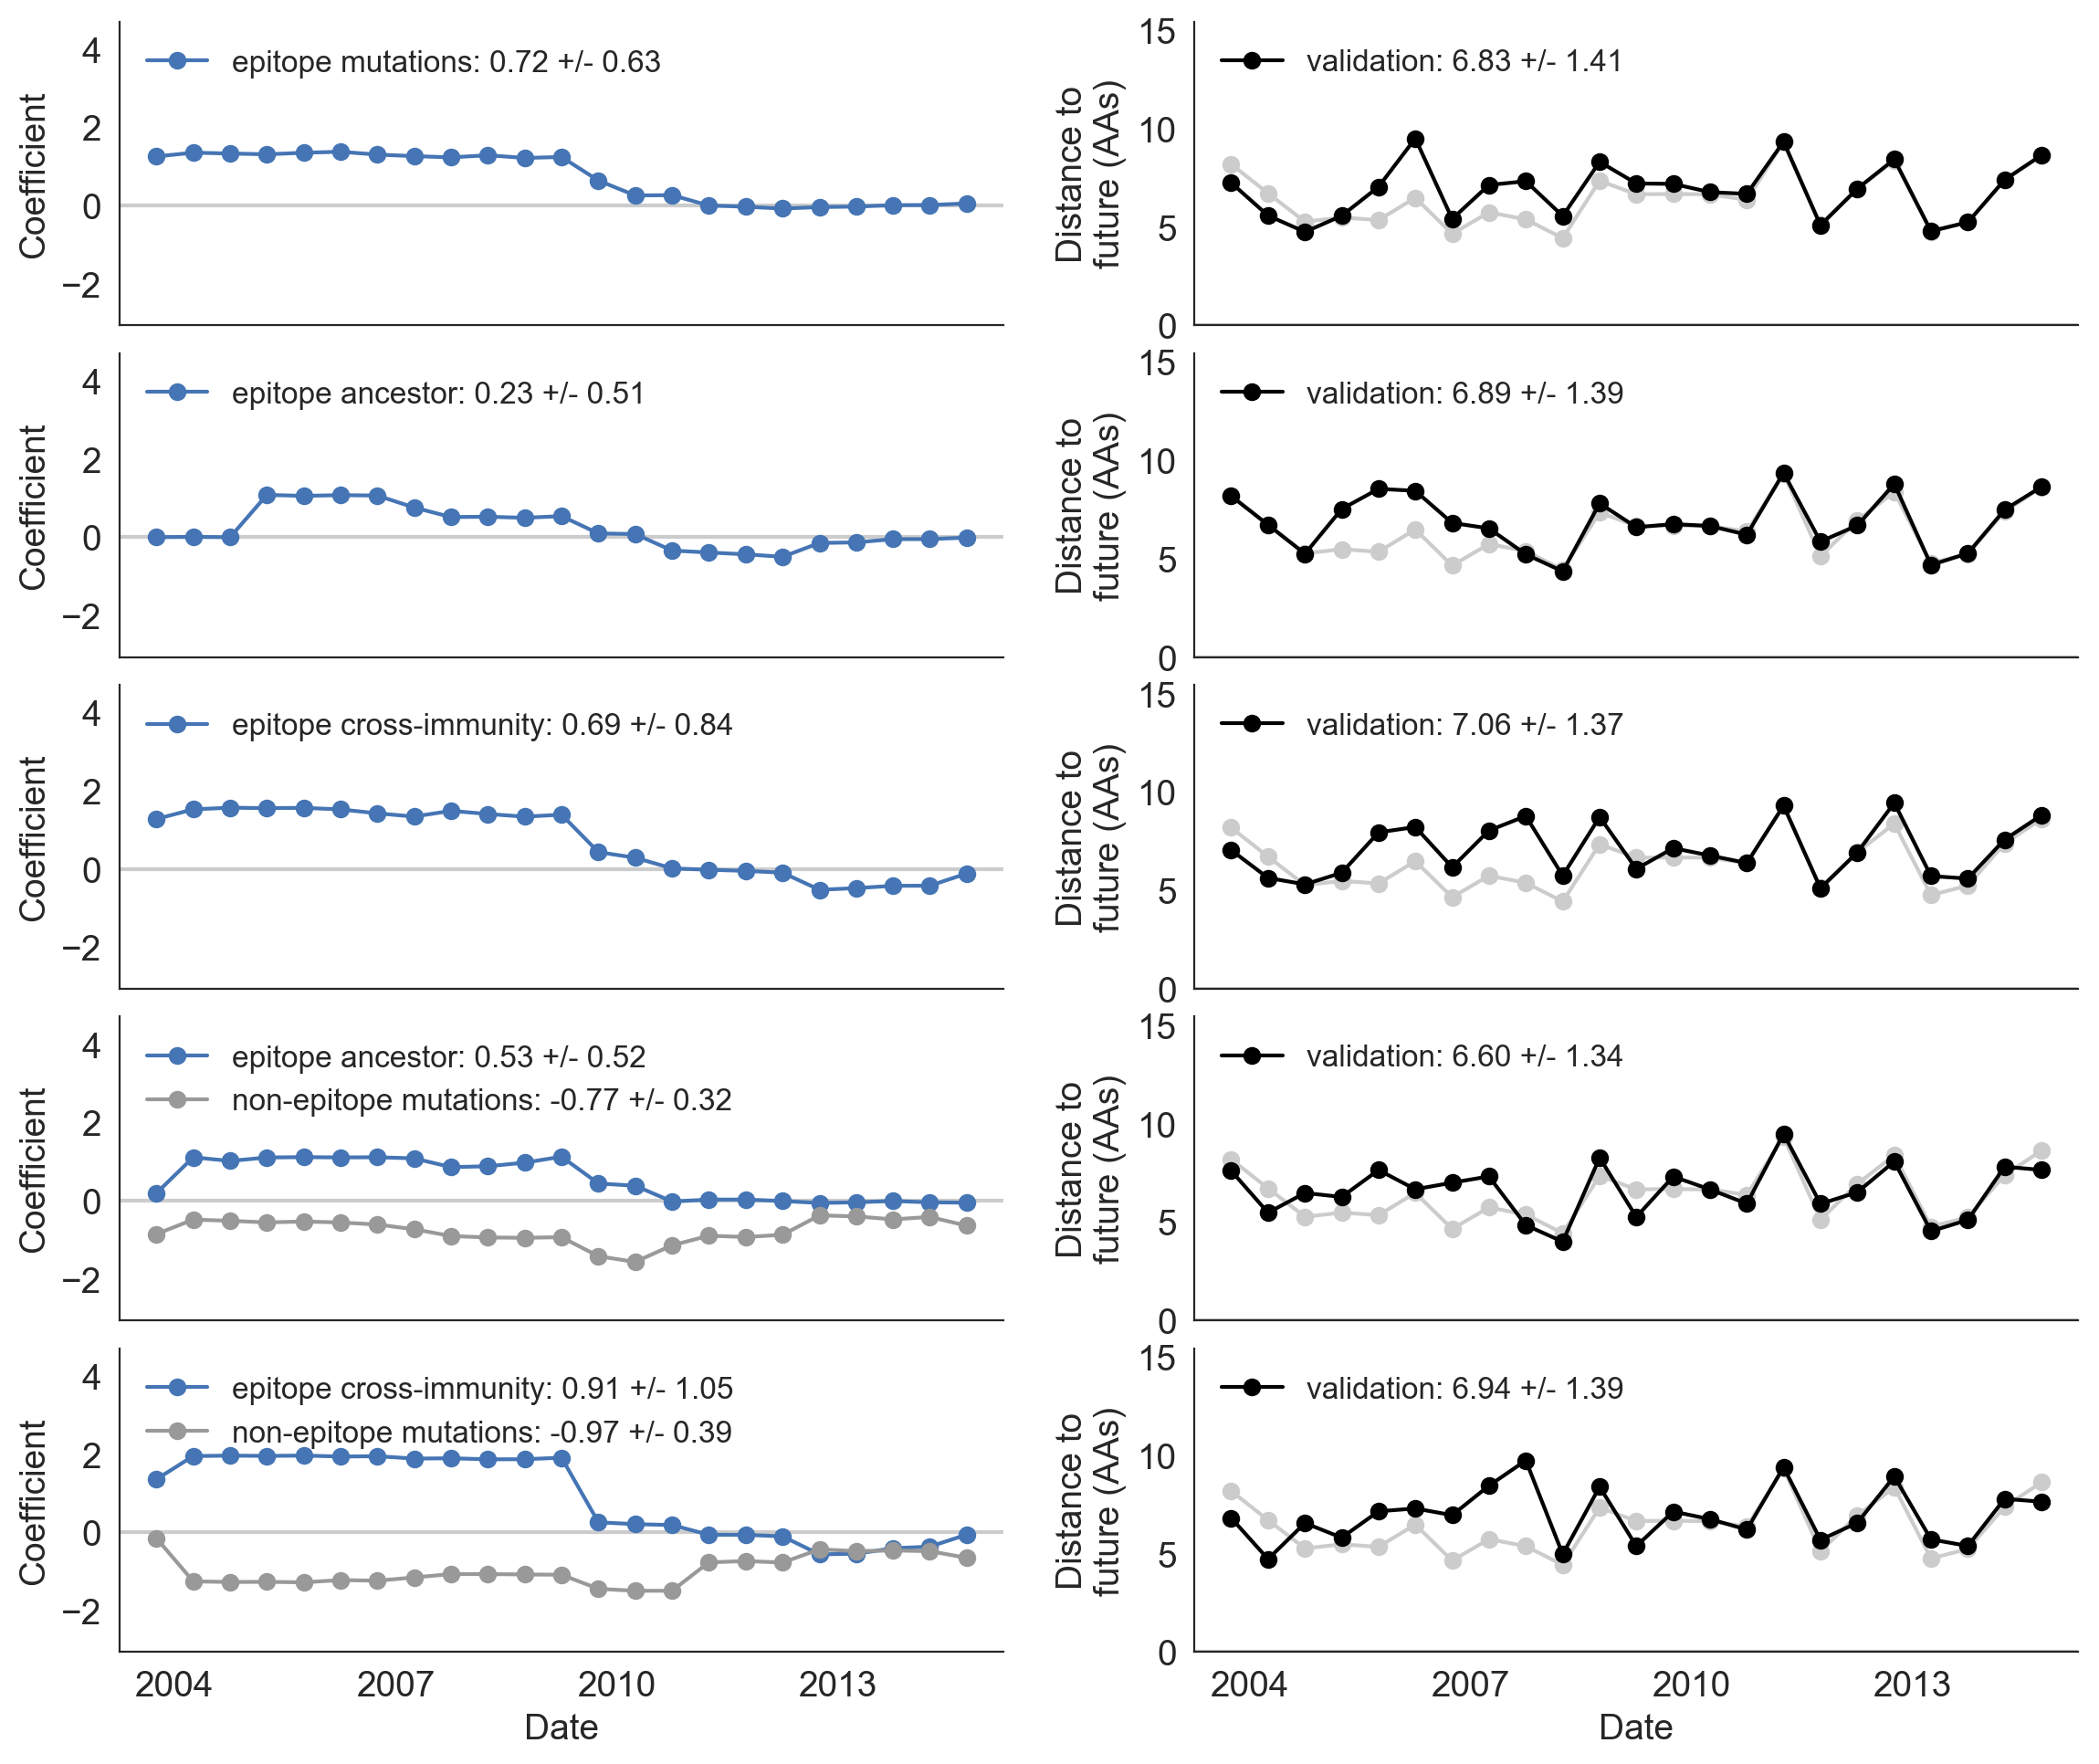

In [815]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["ep", "ep_star", "ep_x", "ep_star-ne_star", "ep_x-ne_star"],
    height=10,
    rotation=0,
    #error_attribute="validation_error"
)
#plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-natural-populations-all-composite-predictors.png")

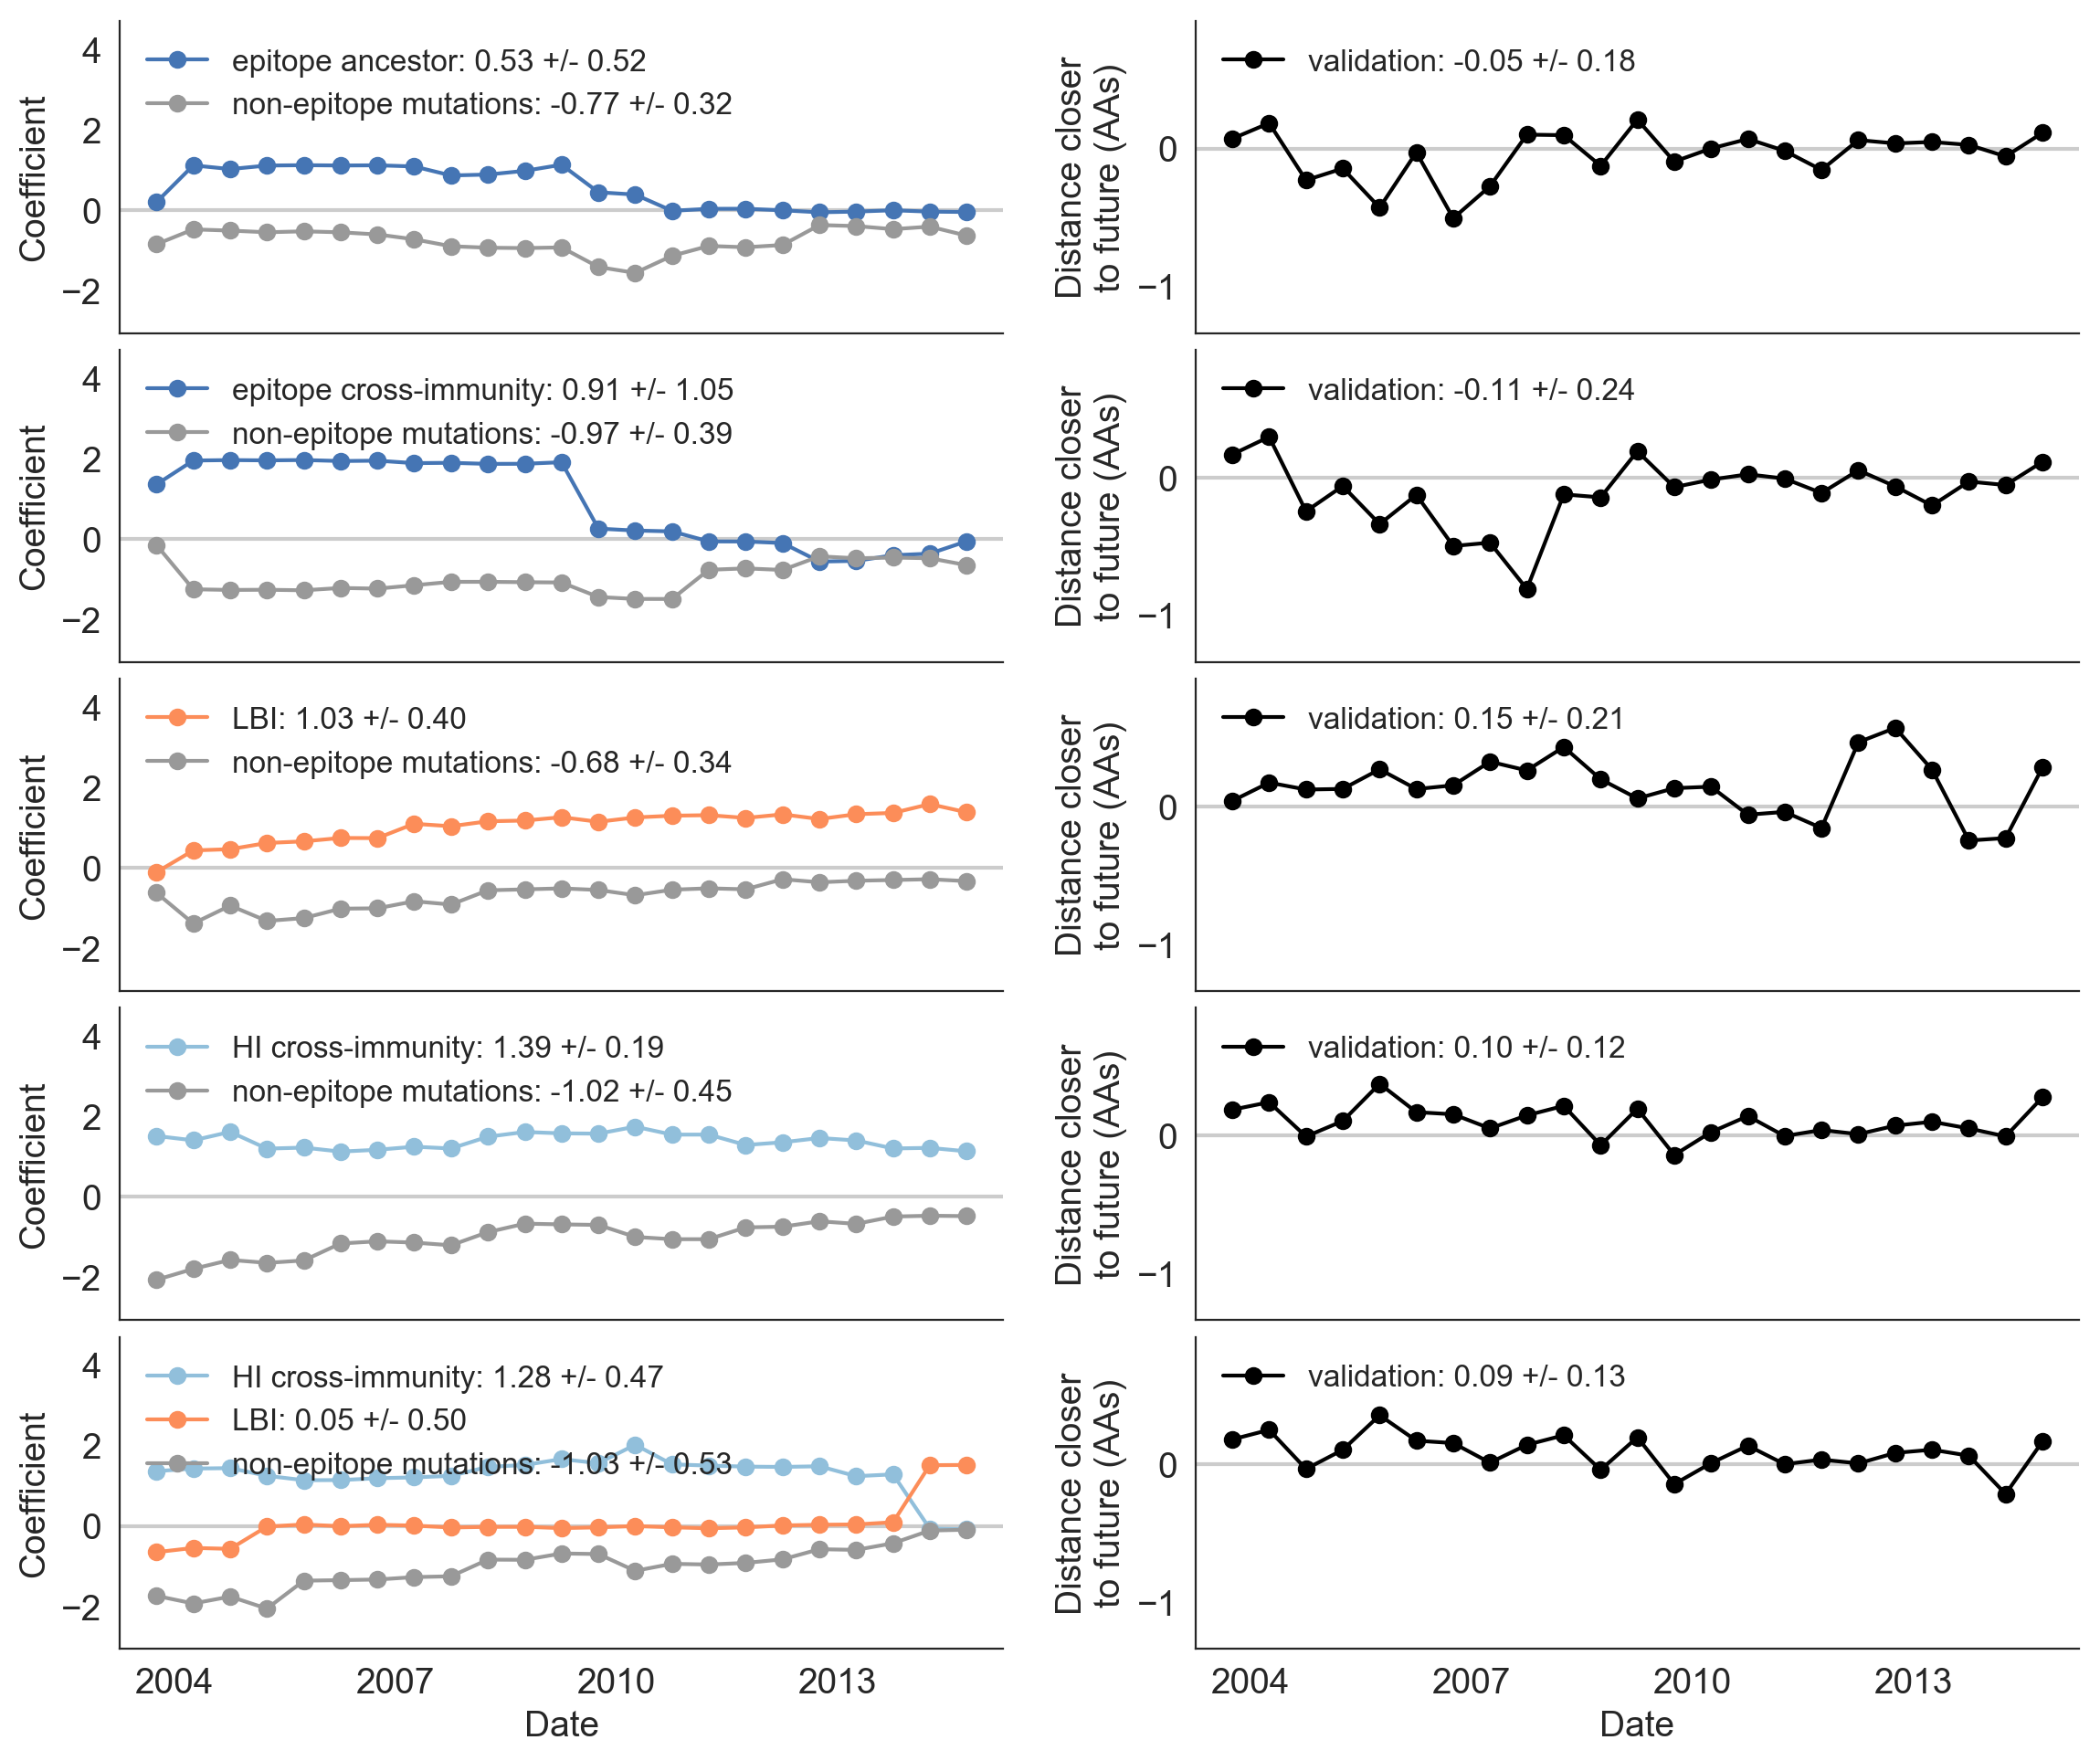

In [227]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    get_composite_predictors_for_data_frame(natural_errors_by_time_df),
    height=10,
    rotation=0
)
#plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-natural-populations-all-composite-predictors.png")

### Individual models

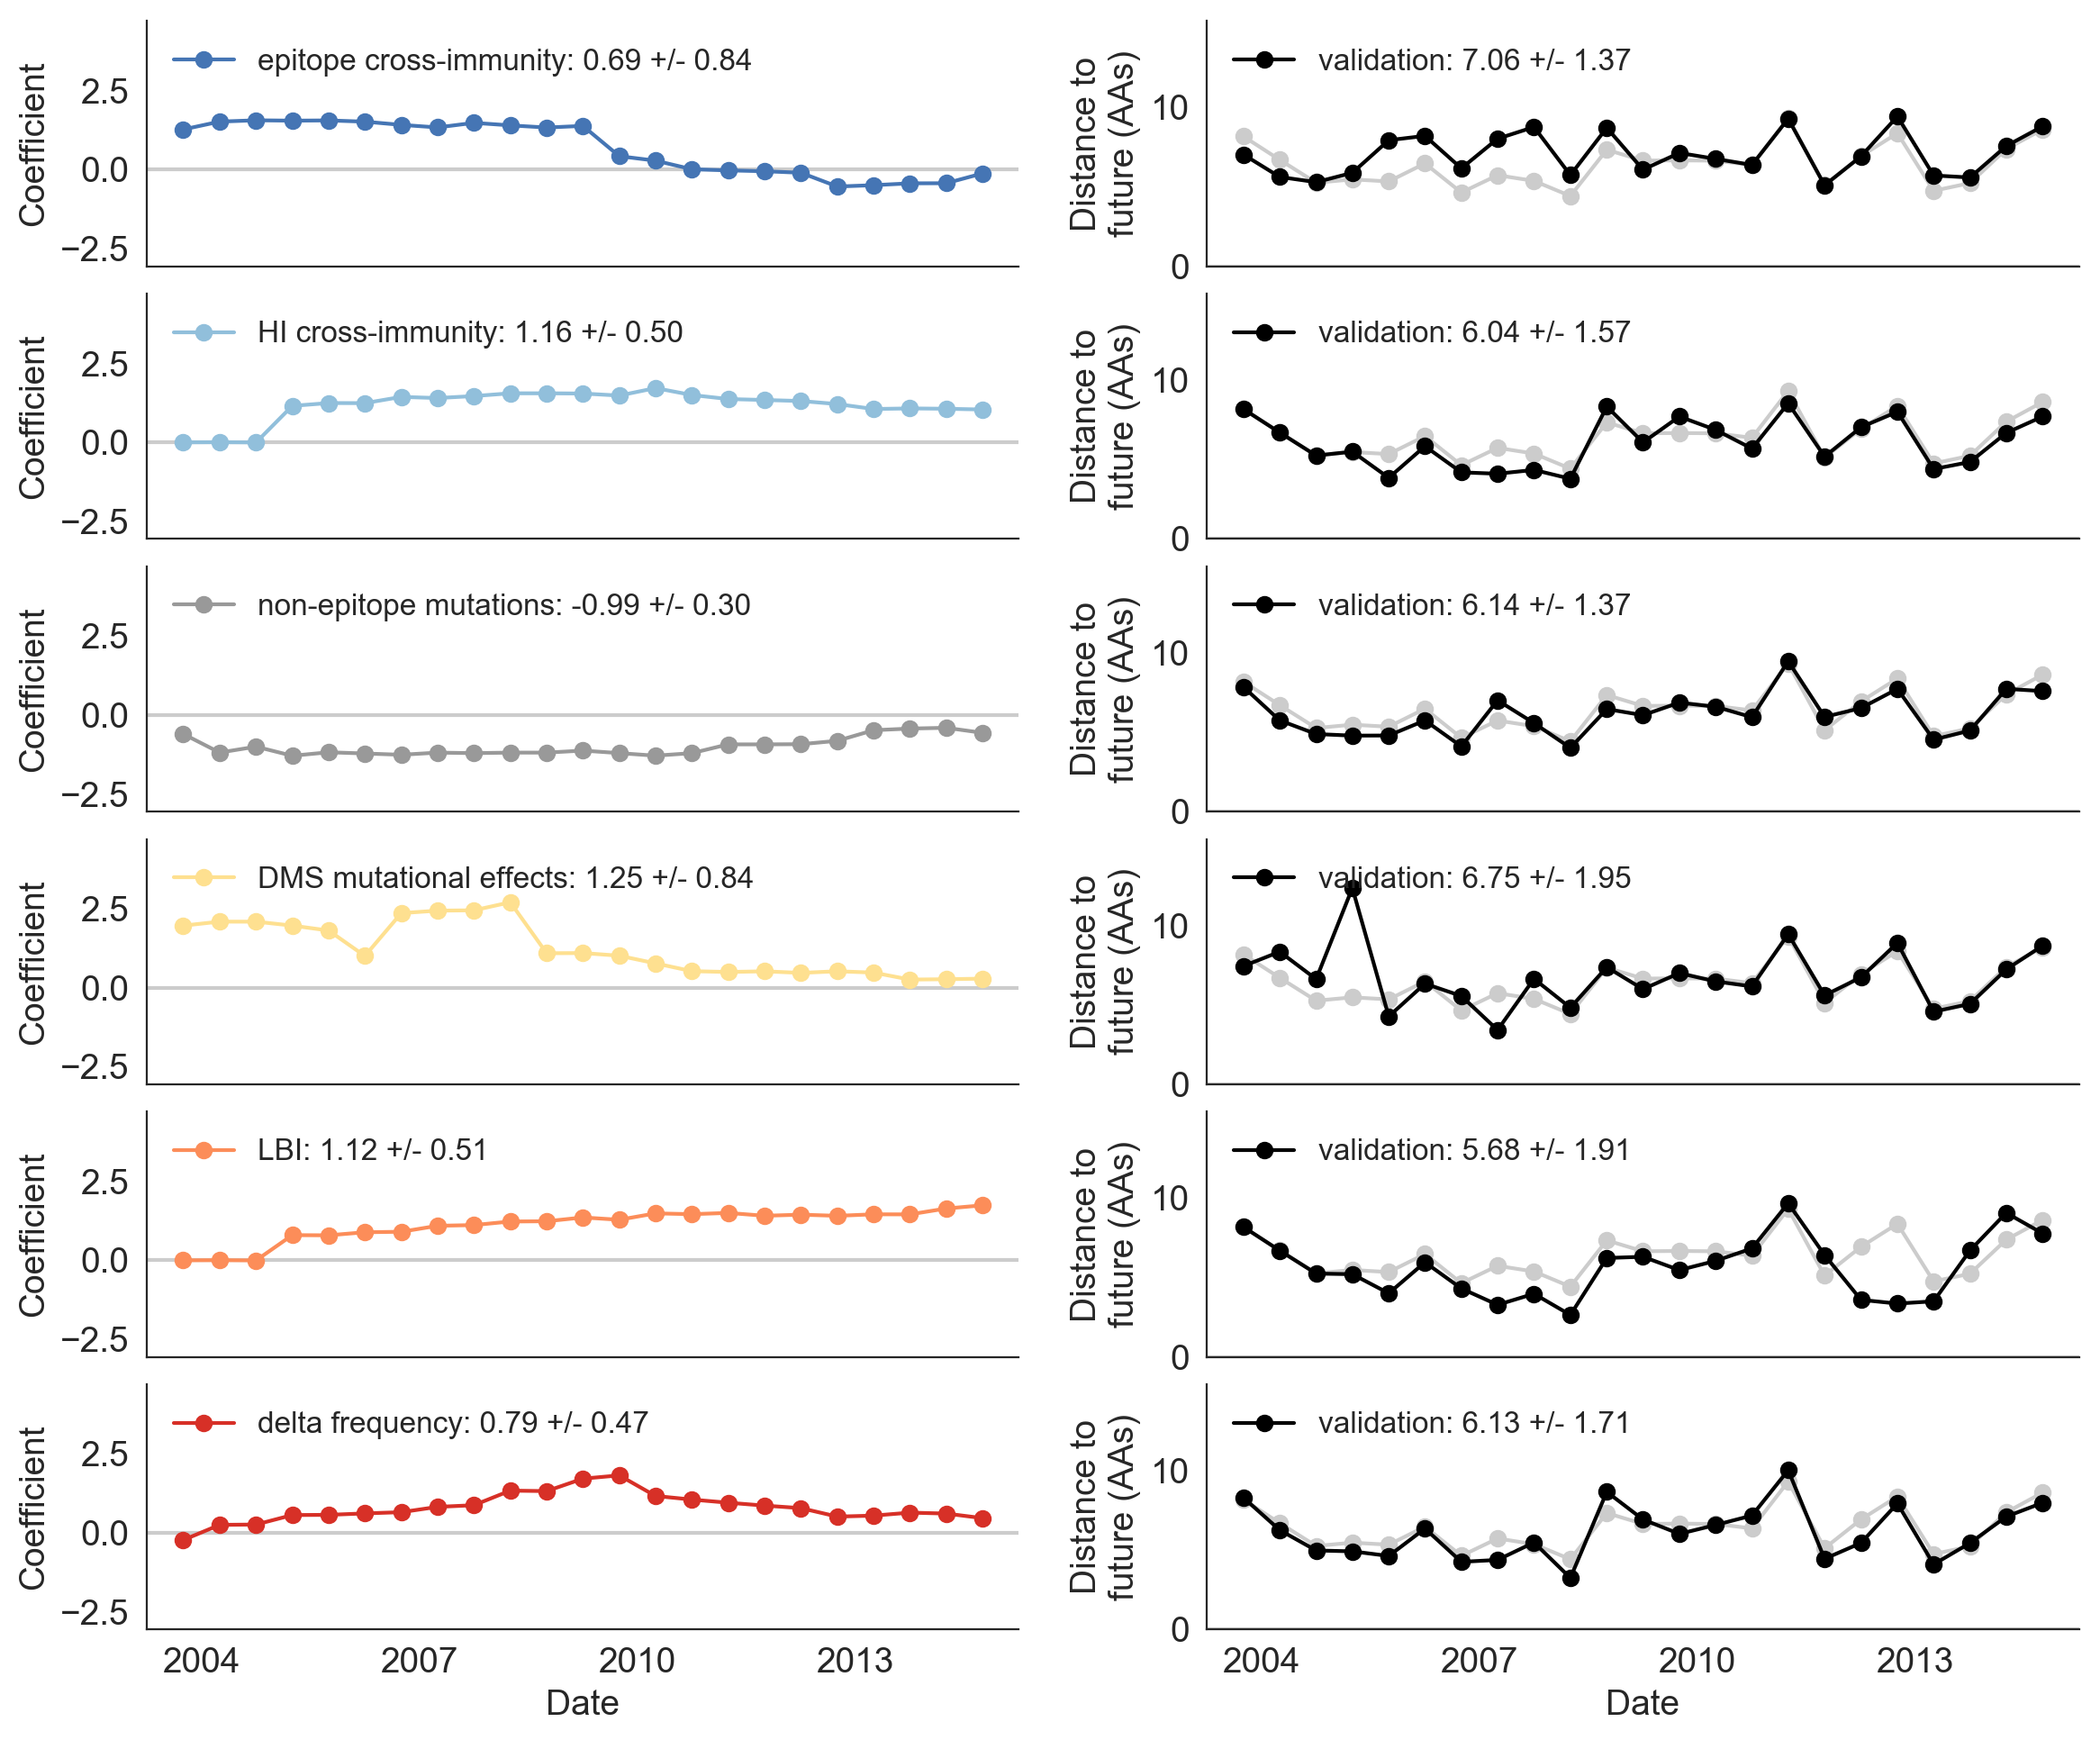

In [828]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    subset_of_individual_predictors,
    height=10,
    rotation=0
)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

### Within category model comparisons

#### Antigenic

In [ ]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["ep", "ep_x", "ep_wolf", "rb"],
    height=8,
    rotation=0
)
plt.savefig("../manuscript/figures/unadjusted-epitope-model-accuracy-and-coefficients-for-natural-populations.png")

In [ ]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["cTiter", "cTiter_x", "cTiterSub", "cTiterSub_x"],
    height=8,
    rotation=0
)
plt.savefig("../manuscript/figures/unadjusted-HI-model-accuracy-and-coefficients-for-natural-populations.png")

#### Functional

In [ ]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["dms_star", "dms_entropy", "dms_nonepitope", "ne_star"],
    height=8,
    rotation=0
)
plt.savefig("../manuscript/figures/unadjusted-DMS-model-accuracy-and-coefficients-for-natural-populations.png")

#### All categories

In [ ]:
within_category_composite_predictors = [
    "ep_x-cTiter_x",
    "ne_star-dms_star",
    "lbi-delta_frequency"
]

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    within_category_composite_predictors,
    height=6,
    text_vertical_padding=0.15
)
plt.savefig("../manuscript/figures/within-category-composite-unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

### Composite models

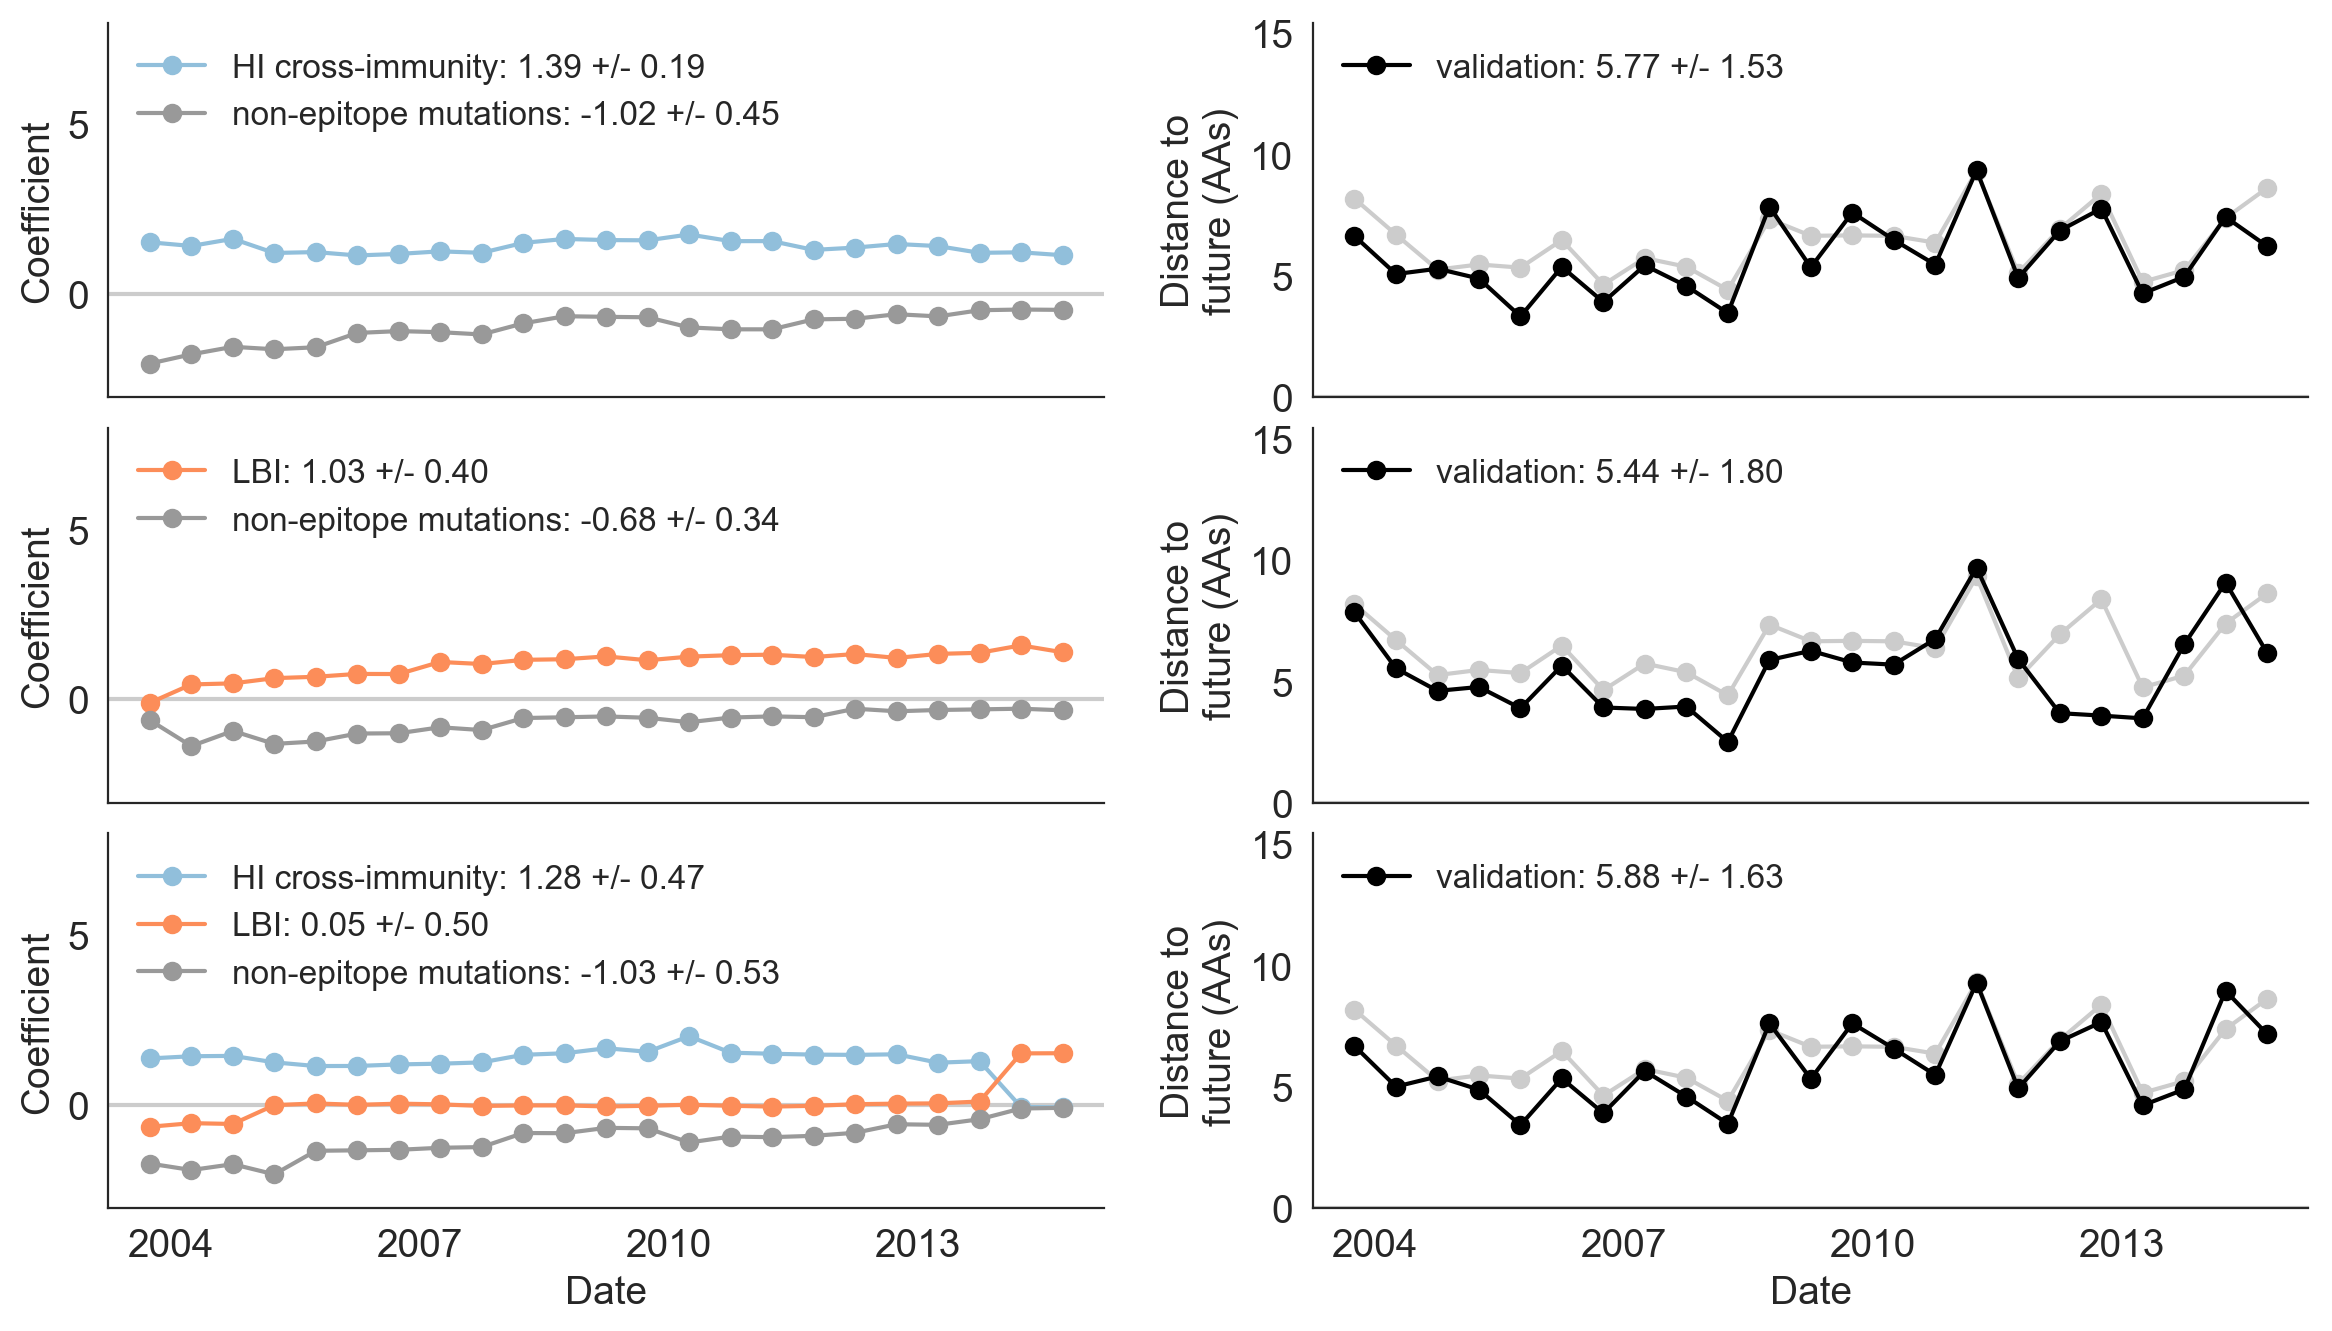

In [833]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    composite_models,
    height=7,
    text_vertical_padding=0.12,
    max_coefficient=8,
    rotation=0
)
plt.savefig("../manuscript/figures/best-composite-unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

### Best three-metric composite models

In [ ]:
best_three_metric_model = [
    "lbi-cTiter_x-ne_star",
    "delta_frequency-cTiter_x-ne_star"
]

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    best_three_metric_model,
    height=5
)
#plt.savefig("../manuscript/figures/best-three-metric-unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

In [ ]:
naive_error_df.head()

In [ ]:
naive_error_df.tail()

Calculate sum of differences between the estimated distances from the naive model and each biological model. The higher sum per model, the more the biological model outperforms the naive model.

In [ ]:
naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()

In [ ]:
natural_errors_by_time_with_naive_df = natural_errors_by_time_df.merge(
    naive_error_df,
    on=["validation_timepoint", "validation_n", "type", "sample"],
    suffixes=["_model", "_naive"]
)

In [ ]:
natural_errors_by_time_with_naive_df["model_gain"] = (
    natural_errors_by_time_with_naive_df["validation_error_naive"] - natural_errors_by_time_with_naive_df["validation_error_model"]
)

In [ ]:
natural_errors_by_time_with_naive_df.head()

In [ ]:
natural_errors_by_time_with_naive_df.groupby("predictors_model")["model_gain"].sum().sort_values(ascending=False)

## Figure 4: Summary of models for Luksza and Lassig populations

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    luksza_errors_by_time_df,
    luksza_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(luksza_errors_by_time_df),
    height=6
)
#plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-luksza-lassig-populations.png")

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    luksza_errors_by_time_df,
    luksza_coefficients_by_time_df,
    ["lbi", "ep_x", "ne_star"] + get_composite_predictors_for_data_frame(luksza_errors_by_time_df)
)
#plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-luksza-lassig-populations.png")

## Cross-validation figures

In [ ]:
def plot_cross_validation_times(data, ax, years_fmt_string):
    """
    """
    timepoints = data.loc[:, ["validation_timepoint", "error_type"]].drop_duplicates()
    y_positions = list(range(len(timepoints.values)))
    
    validation_timepoints = timepoints.query("error_type == 'validation'").loc[:, "validation_timepoint"].apply(
        lambda time: time.toordinal()
    ).values
    validation_y_positions = y_positions[:len(validation_timepoints)]

    test_timepoints = timepoints.query("error_type == 'test'").loc[:, "validation_timepoint"].apply(
        lambda time: time.toordinal()
    ).values
    test_y_positions = y_positions[len(validation_timepoints):]
    
    one_year = pd.DateOffset(years=1)
    training_window = pd.DateOffset(years=6)
    
    training_line_segments = [
        [((timepoint - one_year - training_window).toordinal(), y), ((timepoint - one_year).toordinal(), y)]
        for timepoint, y in zip(timepoints.query("error_type == 'validation'").loc[:, "validation_timepoint"], validation_y_positions)
    ]

    markersize = 4
    years = mdates.YearLocator(5)
    years_fmt = mdates.DateFormatter(years_fmt_string)
    months = mdates.MonthLocator()

    training_lc = LineCollection(training_line_segments, zorder=9)
    training_lc.set_color("#999999")
    training_lc.set_linewidth(1)
    training_lc.set_label("Training")
    training_artist = ax.add_collection(training_lc)

    validation_artist, = ax.plot(
        validation_timepoints,
        validation_y_positions,
        "o",
        label="Validation",
        markersize=markersize,
        color="#000000"
    )
    test_artist, = ax.plot(
        test_timepoints,
        test_y_positions,
        "o",
        label="Test",
        markersize=markersize,
        color="#000000",
        fillstyle="none"
    )

    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    ax.format_xdata = mdates.DateFormatter("%y-%m")

    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y',size=0)
    ax.set_yticklabels([])

    handles = [training_artist, validation_artist]
    labels = ["Training", "Validation"]
    
    if len(test_timepoints) > 0:
        handles.append(test_artist)
        labels.append("Test")
    
    ax.legend(
        handles,
        labels,
        frameon=False
    )
    
    ax.set_xlabel("Date")
    
    return ax

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax = plot_cross_validation_times(simulated_errors_by_time_df, ax, years_fmt_string="%y")
fig.autofmt_xdate(rotation=0, ha="center")

plt.savefig("../manuscript/figures/cross-validation-for-simulated-populations.png")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax = plot_cross_validation_times(natural_errors_by_time_df, ax, years_fmt_string="%Y")
fig.autofmt_xdate(rotation=0, ha="center")

plt.savefig("../manuscript/figures/cross-validation-for-natural-populations.png")

## Figures for presentations

Subsets of models for presentations.

In [ ]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    simulated_errors_by_time_df,
    simulated_coefficients_by_time_df,
    ["normalized_fitness"],
    rotation=0,
    years_fmt_string="%y",
    date_fmt_string="%y-%m",
    height=3,
    hspace=0.1,
    share_y=True,
    max_coefficient=14.5
#    max_normal_error=10
)
plt.savefig("../manuscript/figures/models-simulated-populations-true-fitness.png")

In [ ]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    simulated_errors_by_time_df,
    simulated_coefficients_by_time_df,
    ["normalized_fitness", "ep_x", "ne_star"],
    rotation=0,
    years_fmt_string="%y",
    date_fmt_string="%y-%m",
    height=6,
    hspace=0.1,
    share_y=True,
    max_coefficient=14.5
#    max_normal_error=10
)
plt.savefig("../manuscript/figures/models-simulated-populations-true-fitness-and-mechanistic.png")

In [ ]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    simulated_errors_by_time_df,
    simulated_coefficients_by_time_df,
    ["normalized_fitness", "lbi", "delta_frequency"],
    rotation=0,
    years_fmt_string="%y",
    date_fmt_string="%y-%m",
    height=6,
    hspace=0.1,
    share_y=True,
    max_coefficient=14.5
#    max_normal_error=10
)
plt.savefig("../manuscript/figures/models-simulated-populations-true-fitness-and-growth.png")

In [ ]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    simulated_errors_by_time_df,
    simulated_coefficients_by_time_df,
    ["normalized_fitness", "ep_x-ne_star", "lbi-ne_star"],
    rotation=0,
    years_fmt_string="%y",
    date_fmt_string="%y-%m",
    height=6,
    hspace=0.1,
    share_y=True,
    max_coefficient=14.5
#    max_normal_error=10
)
plt.savefig("../manuscript/figures/models-simulated-populations-true-fitness-and-composite.png")

In [ ]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["ep_x", "cTiter_x"],
    rotation=0,
    years_fmt_string="%Y",
    date_fmt_string="%Y-%m",
    height=4.5,
    hspace=0.1,
    share_y=True,
#    max_coefficient=14.5
#    max_normal_error=10
)
plt.savefig("../manuscript/figures/models-natural-populations-antigenic.png")

In [ ]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["ne_star", "dms_star"],
    rotation=0,
    years_fmt_string="%Y",
    date_fmt_string="%Y-%m",
    height=4.5,
    hspace=0.1,
    share_y=True,
#    max_coefficient=14.5
#    max_normal_error=10
)
plt.savefig("../manuscript/figures/models-natural-populations-functional.png")

In [ ]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["lbi", "delta_frequency"],
    rotation=0,
    years_fmt_string="%Y",
    date_fmt_string="%Y-%m",
    height=4.5,
    hspace=0.1,
    share_y=True,
#    max_coefficient=14.5
#    max_normal_error=10
)
plt.savefig("../manuscript/figures/models-natural-populations-growth.png")

In [ ]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["ep_x-ne_star", "cTiter_x-ne_star", "ne_star-lbi"],
    rotation=0,
    years_fmt_string="%Y",
    date_fmt_string="%Y-%m",
    height=6,
    hspace=0.1,
    share_y=True,
    max_coefficient=6.0
#    max_normal_error=10
)
plt.savefig("../manuscript/figures/models-natural-populations-composite.png")

In [ ]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["cTiter_x-ne_star-lbi"],
    rotation=0,
    years_fmt_string="%Y",
    date_fmt_string="%Y-%m",
    height=3,
    hspace=0.1,
    share_y=True,
    max_coefficient=6.0
#    max_normal_error=10
)
plt.savefig("../manuscript/figures/models-natural-populations-three-metric-composite.png")